# Прогнозирование удовлетворенности и оттока сотрудников.

## Введение

**Цель проекта**

Разработать решение, которое позволит оптимизировать управление персоналом и избежать оттока сотрудников.

**Задачи проекта**
1. Разработка модели для предсказания уровня удовлетворенности сотрудников.
2. Разработка модели для предсказания увольнения сотрудников.
____

**О данных**

**Датасет train_job_satisfaction_rate** содержит обучающие данные для предсказания удовлетворенности сотрудников.

**Датасет train_quit** содержит обучающие данные для предсказания увольнения сотрудников.

**Датасет test_features** содержит тестовые данные для проверки эффективности обеих моделей.

Все три датасета содержат следующий набор информации:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак *(есть только train_job_satisfaction_rate)*
- quit - информация о факте увольнения сотрудника *(есть только train_quit)*

**Датасет test_target_job_satisfaction_rate** содержит целевой признак job_satisfaction_rate для тестовой выборки.

**Датасет test_target_quit** содержит целевой признак quit для тестовой выборки.
_____

**План проекта**

Для разработки каждой модели будут реализованы следующие шаги.
1. Обзор и предобработка данных
2. Исследовательский анализ данных
3. Корреляционный анализ
4. Обучение и выбор моделей
5. Анализ важности признаков

Далее будет описан общий вывод.

## Импорт библиотек

In [1]:
#импортируем библиотеки для работы

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sys
!{sys.executable} -m pip install phik -q
from phik import phik_matrix

!pip install -U scikit-learn -q

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder)

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (roc_auc_score, 
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.inspection import permutation_importance


!pip install shap -q
import shap

## Функции для работы

In [2]:
#функция для обзора данных
def data_overview(data):
    display(data.head(10))
    print('')
    display(data.sample(10))
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('')
    print('Кол-во пропусков:')
    display(data.isna().sum())
    print('')

In [3]:
#функция для обзора категориальных признаков в тренировочных и тестовых данных
def cutie_pie_chart_for_two(data_train, data_test, column, the_title):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    palette = ['#ADD8E6', '#87CEEB', '#4682B4', 
               '#1E90FF', '#00BFFF', '#5F9EA0', '#00CED1']
    fig.suptitle(f"{the_title}", fontsize=16)
    
    data_train[column].value_counts().plot(
        kind='pie',
        title='Обучающие данные',
        autopct='%.0f%%',
        ylabel='',
        ax=axes[0],
        colors=palette)

    data_test[column].value_counts().plot(
        kind='pie',
        title='Тестовые данные',
        autopct='%.0f%%',
        ylabel='',
        ax=axes[1],
        colors=palette)
    
    plt.tight_layout()
    plt.show()

In [4]:
#функция для обзора ёмких дискретных признаков в тренировочных и тестовых данных
def countplot_for_two(data_train, data_test, column, title, y_label, x_label):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    color='#6495ED'
    fig.suptitle(f"{title}", fontsize=16)
    
    sns.countplot(x=column, data=data_train, color=color, ax=axes[0])
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[0].set_title("Обучающие данные")

    sns.countplot(x=column, data=data_test, color=color, ax=axes[1])
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)
    axes[1].set_title("Тестовые данные")
    
    plt.tight_layout()
    plt.show()

In [5]:
#функция для обзора неприрывных количественных признаков
def hist_and_box_chart(data, column, title, y_label, x_label, bins):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"{title}", fontsize=16)
    palette = ['#87CEEB', '#4682B4', '#1E90FF', 
               '#00BFFF', '#00CED1', '#40E0D0', 
               '#468499', '#B0E0E6', '#66CDAA', '#6495ED']
    
    # Гистограмма
    data[column].plot(
        kind='hist',
        alpha=0.7,
        ax=axes[0],
        color=palette[:len(column)],
        bins=bins
    )
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[0].set_title("Гистограмма")

    median = data[column].median()
    mean = data[column].mean()
    axes[0].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
    axes[0].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
    axes[0].legend()


    # Боксплот
    data[column].plot(
        kind='box',
        ax=axes[1],
        vert=False,
        color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'}
    )
    axes[1].set_xlabel(x_label)
    axes[1].set_yticklabels([])
    axes[1].set_ylabel('')
    axes[1].set_title("Диаграмма размаха")

    plt.tight_layout()
    plt.show()


In [6]:
#функция для оценки модели - симметричное среднее абсолютное процентное отклонение
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0 
    diff = np.abs(y_true - y_pred) / denominator    
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

In [7]:
#функция для рассмотрения признаков в контексте увольнения: какой процент сотрудников увольняется в разных группах
def quit_percent_plot(feature, title, xlabel):
    percent_data = (
    train_quit.groupby([feature, 'quit'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .reset_index(name='percent'))
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=percent_data, x=feature, y='percent', hue='quit',
            palette=['#87CEEB', '#A12343'])
    plt.title(title, fontsize=16)
    plt.ylabel("Процент")
    plt.xlabel(xlabel)
    plt.show()

## Прогнозирование удовлетворенности сотрудников

### Предобработка данных

#### Импорт и обзор данных

In [8]:
#импортируем обучающие данные для модели по удовлетворенности сотрудников, тестовые входные данные и тестовые данные с целевым признаком
try:
    train_job_satisfaction_rate = pd.read_csv('Desktop/practicum cases/train_job_satisfaction_rate.csv')
except:
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

try:
    test_features = pd.read_csv('Desktop/practicum cases/test_features.csv')
except:
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

try:
    test_target_job_satisfaction_rate = pd.read_csv('Desktop/practicum cases/test_target_job_satisfaction_rate.csv')
except:
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')


In [9]:
data_overview(train_job_satisfaction_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1247,996910,sales,junior,low,2,no,no,4,12000,0.70
3471,922208,marketing,middle,medium,10,no,no,5,46800,0.90
2676,970439,purchasing,middle,low,3,no,no,4,24000,0.72
550,720658,technology,middle,medium,4,no,yes,3,50400,0.24
2146,229741,sales,sinior,high,2,no,no,5,79200,0.66
1043,478080,purchasing,junior,medium,3,no,no,4,22800,0.63
3406,888815,sales,middle,medium,8,no,no,5,38400,0.84
3370,814374,marketing,junior,low,1,no,no,4,16800,0.76
1257,813883,hr,sinior,high,10,no,no,4,67200,0.66
2911,449098,marketing,junior,low,2,no,yes,4,14400,0.43



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [10]:
data_overview(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1934,951029,marketing,junior,medium,2,no,no,5,24000
1572,135704,sales,junior,medium,3,no,yes,2,20400
208,331711,sales,junior,medium,4,no,yes,3,20400
1342,862904,sales,middle,medium,9,no,no,3,37200
763,471840,technology,junior,low,1,no,yes,3,21600
1321,709552,purchasing,junior,low,2,no,no,4,15600
228,348960,marketing,middle,low,3,no,no,4,20400
235,108816,purchasing,middle,medium,9,no,yes,1,32400
1978,644517,purchasing,middle,medium,4,no,no,4,39600
1157,375198,sales,middle,medium,6,no,no,2,36000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [11]:
data_overview(test_target_job_satisfaction_rate)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


,id,job_satisfaction_rate
429,591738,0.74
1760,979519,0.79
97,373957,0.43
1717,428870,0.07
1516,912768,0.10
1815,844777,0.58
498,922419,0.74
747,410542,0.33
1534,168007,0.71
998,459572,0.24



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


id                       0
job_satisfaction_rate    0
dtype: int64

In [12]:
test_target_job_satisfaction_rate.nunique()

id                       2000
job_satisfaction_rate      98
dtype: int64

**Итог обзора данных**

**train_job_satisfaction_rate**: данные с оценкой уровня удовлетворенности сотрудников для тренеровочной выборки 

- Названия столбцов ок.
- Проверить неявные дубликаты. 
- Тип данных верный.
- Основные статистики выглядят адекватно.
- Пропущенные значения: 6 в столбце debt и 4 в столбце level. Их мы заполним при создании пайплайна. 
_____

**test_features**: данные для теста с входными признаками

- Названия столбцов ок.
- Проверить неявные дубликаты.
- Тип данных верный.
- Основные статистики выглядят адекватно.
- Пропущенные значения: 2 в столбце debt и 1 в столбце level. Их мы заполним при создании пайплайна.
____

**test_target_job_satisfaction_rate**: данные для теста с целевым значением - с оценкой уровня удовлетворенности сотрудников 

- Названия столбцов ок.
- Явных дубликатов нет, как и неявных - все id уникальные.
- Тип данных верный.
- Основные статистики выглядят адекватно, больше 1 и меньше 0 нет.
- Пропущенных значений нет.
____

У **test_features** и **test_target_job_satisfaction_rate** сейчас разный порядок id, что создаст в дальнейшем сложности для сверки предсказания и истинного значения.
Для уменьшения путаницы и числа сущностей мы эти таблицы объединим.

#### Проверка на неявные дубликаты 

In [13]:
#проверим наличие опечаток или других погрешностей, в которых могли скрыться неявные дубликаты
print('Число уникальных id:', train_job_satisfaction_rate['id'].nunique())
print('')
print(train_job_satisfaction_rate['dept'].value_counts())
print('')
print(train_job_satisfaction_rate['level'].value_counts())
print('')
print(train_job_satisfaction_rate['workload'].value_counts())
print('')
print(train_job_satisfaction_rate['last_year_promo'].value_counts())
print('')
print(train_job_satisfaction_rate['last_year_violations'].value_counts())
print('')

Число уникальных id: 4000

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64

medium    2066
low       1200
high       734
Name: workload, dtype: int64

no     3880
yes     120
Name: last_year_promo, dtype: int64

no     3441
yes     559
Name: last_year_violations, dtype: int64



- Значения в целом корректные и уникальные, неявным дубликатам тут быть негде.
- Заменим sinior на senior, чтобы меньше нервничать по пустякам.

In [14]:
#заменим и проверим значения в колонке
train_job_satisfaction_rate.loc[train_job_satisfaction_rate['level'] == 'sinior', 'level'] = 'senior'
train_job_satisfaction_rate['level'].value_counts()

junior    1894
middle    1744
senior     358
Name: level, dtype: int64

In [15]:
#и еще раз проверим на дубликаты, чисто для души
print('Кол-во явных дубликатов:', train_job_satisfaction_rate.duplicated().sum())

Кол-во явных дубликатов: 0


In [16]:
#проверим наличие опечаток или других погрешностей, в которых могли скрыться неявные дубликаты
print('Число уникальных id:', test_features['id'].nunique())
print('')
print(test_features['dept'].value_counts())
print('')
print(test_features['level'].value_counts())
print('')
print(test_features['workload'].value_counts())
print('')
print(test_features['last_year_promo'].value_counts())
print('')
print(test_features['last_year_violations'].value_counts())
print('')

Число уникальных id: 2000

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

junior    974
middle    854
sinior    171
Name: level, dtype: int64

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

no     1937
yes      63
Name: last_year_promo, dtype: int64

no     1738
yes     262
Name: last_year_violations, dtype: int64



- Значения в целом корректные и уникальные, неявным дубликатам тут быть негде.
- Заменим sinior на senior, чтобы не попасть в ад.

In [17]:
#заменим и проверим значения в колонке
test_features.loc[test_features['level'] == 'sinior', 'level'] = 'senior'
test_features['level'].value_counts()

junior    974
middle    854
senior    171
Name: level, dtype: int64

In [18]:
#и еще раз проверим на дубликаты, чисто для души
print('Кол-во явных дубликатов:', test_features.duplicated().sum())

Кол-во явных дубликатов: 0


#### Объединение тестовой выборки

In [19]:
#объединим выборки для удобства и тотальности совпадения данных
test_job_satisfaction_rate=pd.merge(test_features, test_target_job_satisfaction_rate, on='id', how='inner')
data_overview(test_job_satisfaction_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
5,429973,purchasing,middle,medium,6,no,no,3,42000,0.67
6,850699,technology,junior,medium,3,no,no,3,26400,0.36
7,500791,sales,middle,high,9,no,no,4,49200,0.73
8,767867,marketing,middle,high,3,no,yes,4,62400,0.44
9,937235,sales,junior,medium,1,no,yes,3,26400,0.22


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
123,558915,hr,middle,medium,5,no,no,3,45600,0.66
1645,137912,marketing,middle,low,4,no,no,5,21600,0.44
1514,756676,technology,junior,medium,1,no,no,5,36000,0.69
787,662691,technology,junior,low,3,no,yes,3,22800,0.29
465,991967,marketing,junior,low,1,no,no,2,16800,0.52
1018,403283,sales,junior,low,1,no,yes,4,15600,0.48
1141,926960,sales,middle,medium,9,no,no,2,36000,0.30
1706,741156,purchasing,junior,medium,1,no,no,1,27600,0.40
992,308908,technology,middle,low,7,no,no,3,21600,0.32
1477,386153,purchasing,middle,low,9,no,yes,4,19200,0.47



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
employment_years,2000.0,3.66650,2.537222,1.00,1.00,3.00,6.00,10.0
supervisor_evaluation,2000.0,3.52650,0.996892,1.00,3.00,4.00,4.00,5.0
salary,2000.0,34066.80000,15398.436729,12000.00,22800.00,30000.00,43200.00,96000.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

- Объединенный файл содержит 2000 id.
- Объединенный файл сохранил все нужные характеристики оригинальных файлов: верный тип данных, отсутствие любых дубликатов, пропуски в dept и level.

#### Выводы по предобработке

**train_job_satisfaction_rate**: данные с оценкой уровня удовлетворенности сотрудников для тренеровочной выборки 

- Названия столбцов и тип данных ок.
- Дубликатов нет, явных и неявных.
- Заменили в столбце 'level' значения 'sinior' на 'senior'.
- Основные статистики выглядят адекватно.
- Пропущенные значения: 6 в столбце debt и 4 в столбце level. Их мы заполним при создании пайплайна.
____

**test_job_satisfaction_rate**: данные с оценкой уровня удовлетворенности сотрудников и их характеристиками для тестовой выборки.

Файл был получен из объединения **test_features** и **test_target_job_satisfaction_rate**, чтобы не было путаницы в id и файлах в принципе.

- Названия столбцов и тип данных ок.
- Дубликатов нет, явных и неявных.
- Заменили в столбце 'level' значения 'sinior' на 'senior'.
- Основные статистики выглядят адекватно.
- Пропущенные значения: 2 в столбце debt и 1 в столбце level. Их мы заполним при создании пайплайна. 



### Исследовательский анализ

#### Категориальные признаки

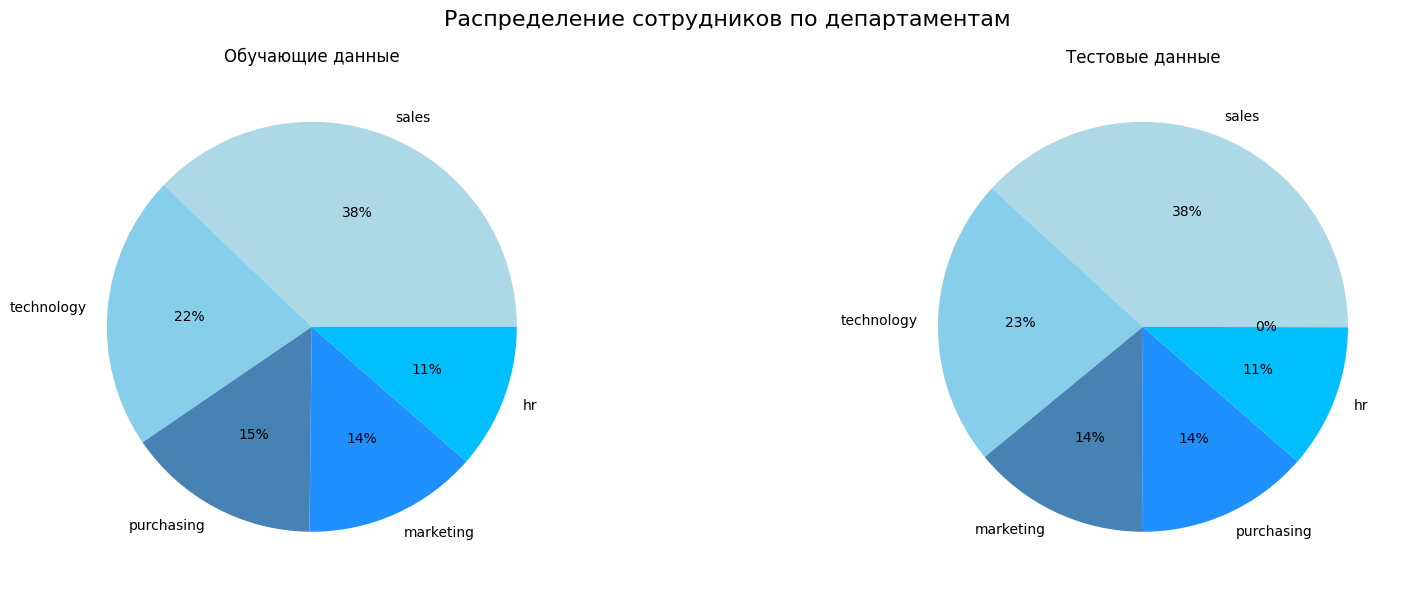

In [20]:
cutie_pie_chart_for_two(train_job_satisfaction_rate, test_job_satisfaction_rate, 'dept', 'Распределение сотрудников по департаментам')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Большая часть сотрудников работают в отделе продаж.
- Меньше всего сотрудников в отделе HR.
- Распределение несколько неравномерное, но выглядит достоверно, не противоречит здравому смыслу и реальности.

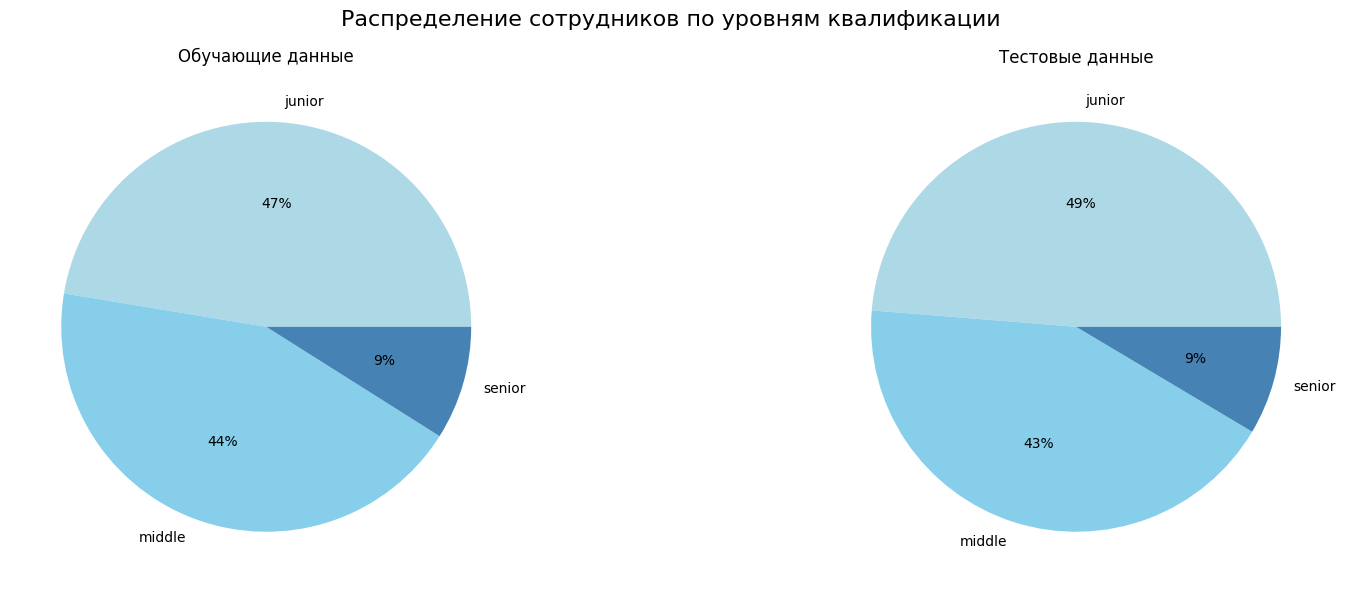

In [21]:
cutie_pie_chart_for_two(train_job_satisfaction_rate, test_job_satisfaction_rate, 'level', 'Распределение сотрудников по уровням квалификации')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Cтарших сотрудников в компании меньше всего, меньше 10%.
- Основная масса сотрудников имеют уровни junior и middle - приблизительно равное число.
- Диспропорция сильная, но более чем реалистичная.

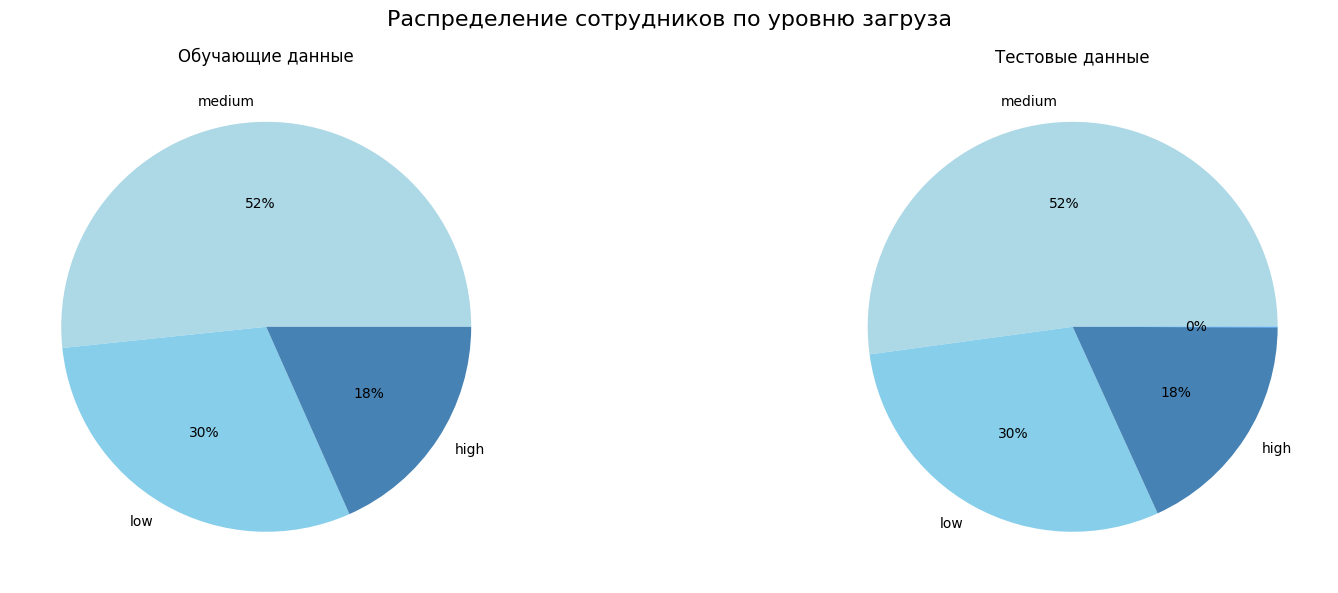

In [22]:
cutie_pie_chart_for_two(train_job_satisfaction_rate, test_job_satisfaction_rate, 'workload', 'Распределение сотрудников по уровню загруза')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Чуть больше половины сотрудников имеют умеренный уровень загруженности.
- Самая малочисленную категорию составляют люди с высоким уровнем загруженности.
- Распределение неравномерное, но реалистичное.

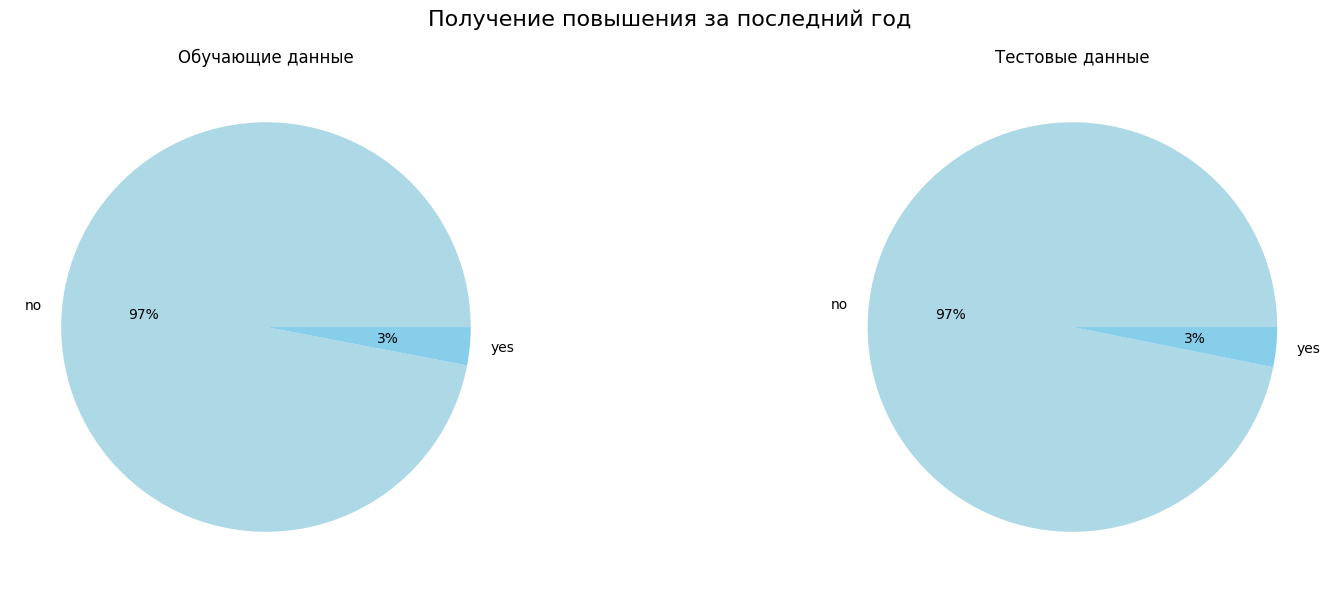

In [23]:
cutie_pie_chart_for_two(train_job_satisfaction_rate, test_job_satisfaction_rate, 'last_year_promo', 'Получение повышения за последний год')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Очень сильная диспропорция: только у 3% сотрудников было повышение за последний год.
- Сложно судить, насколько эта ситуация адекватна: это может быть как нормальный % повышений для компании, так и результатом плохого финансового года, например.

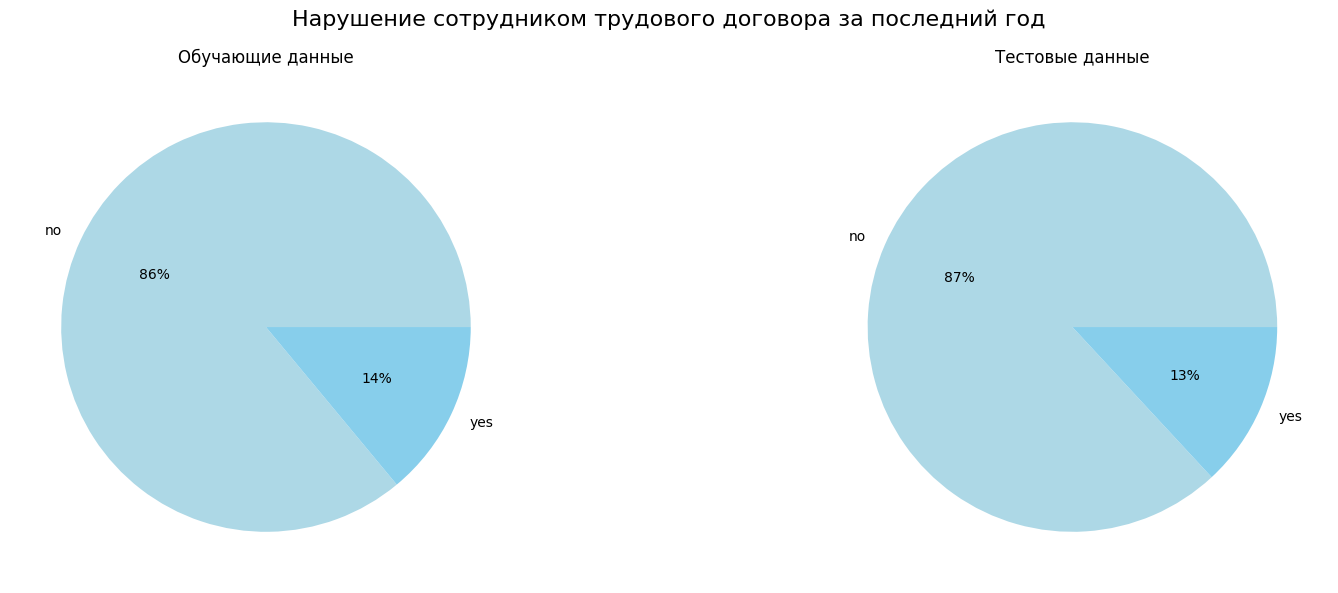

In [24]:
cutie_pie_chart_for_two(train_job_satisfaction_rate, test_job_satisfaction_rate, 'last_year_violations', 'Нарушение сотрудником трудового договора за последний год')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Большая часть сотрудников не имеет фиксированных нарушений.
- Диспропорция заметная, но скорее реалистичная, правдоподобная.

#### Количественные признаки

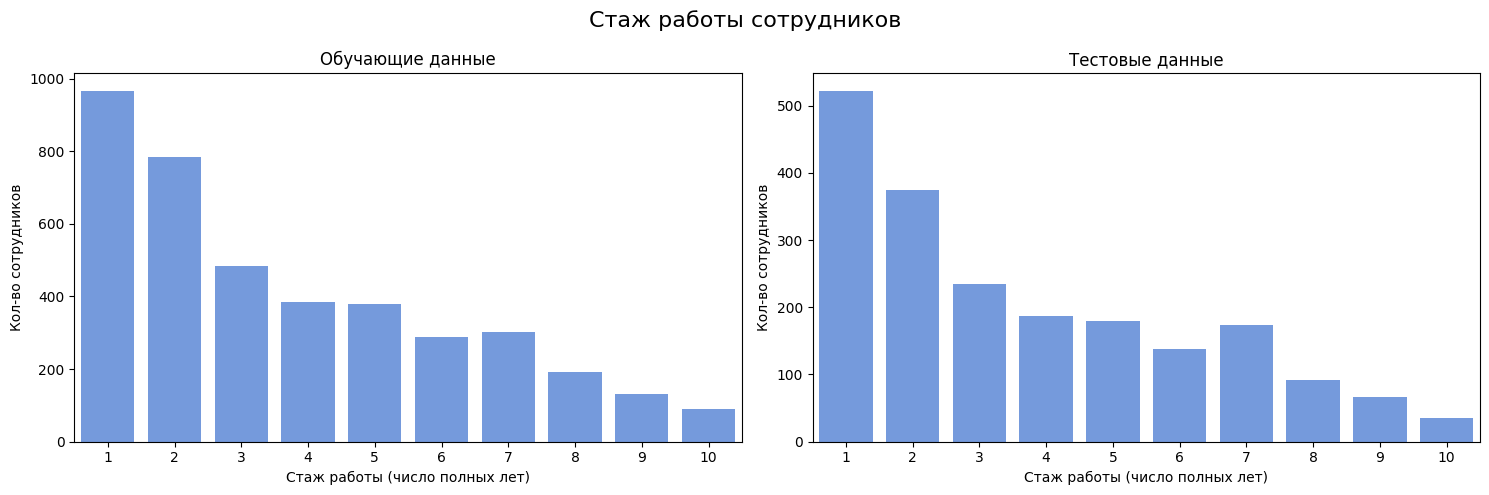

In [25]:
countplot_for_two(train_job_satisfaction_rate, test_job_satisfaction_rate, 'employment_years', 'Стаж работы сотрудников', 'Кол-во сотрудников', 'Стаж работы (число полных лет)')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Половина сотрудников компании имеют стаж в компании не больше 3 лет.
- Дальше значения тем реже, чем они больше (за редким исключением).
- В целом ситуация адекватная, правдоподобная.

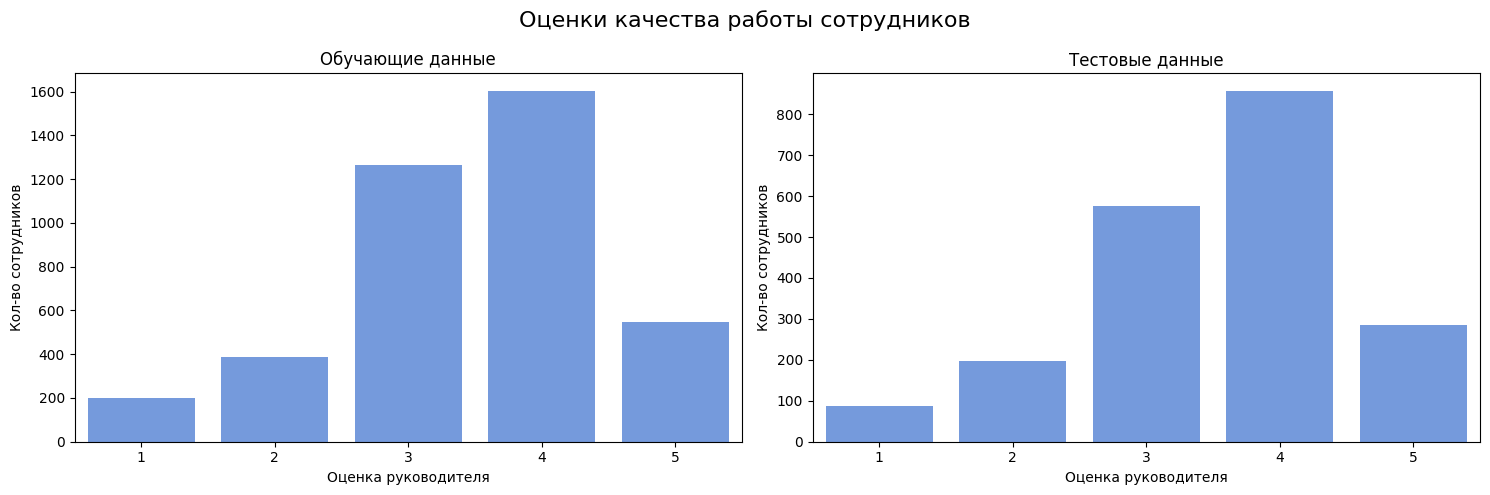

In [26]:
countplot_for_two(train_job_satisfaction_rate, test_job_satisfaction_rate, 'supervisor_evaluation', 'Оценки качества работы сотрудников', 'Кол-во сотрудников', 'Оценка руководителя')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Большинство сотрудников имеют оценки работы 3 и 4.
- Очень низких значений (2 и 1) почти столько же, сколько очень высоких (5).
- В целом и обилие средних оценок и редкость очень плохих оценок выглядят правдоподобно - очень плохих сотрудников и не может быть много, тогда бы плохой результат был нормальным, т.е. средним.

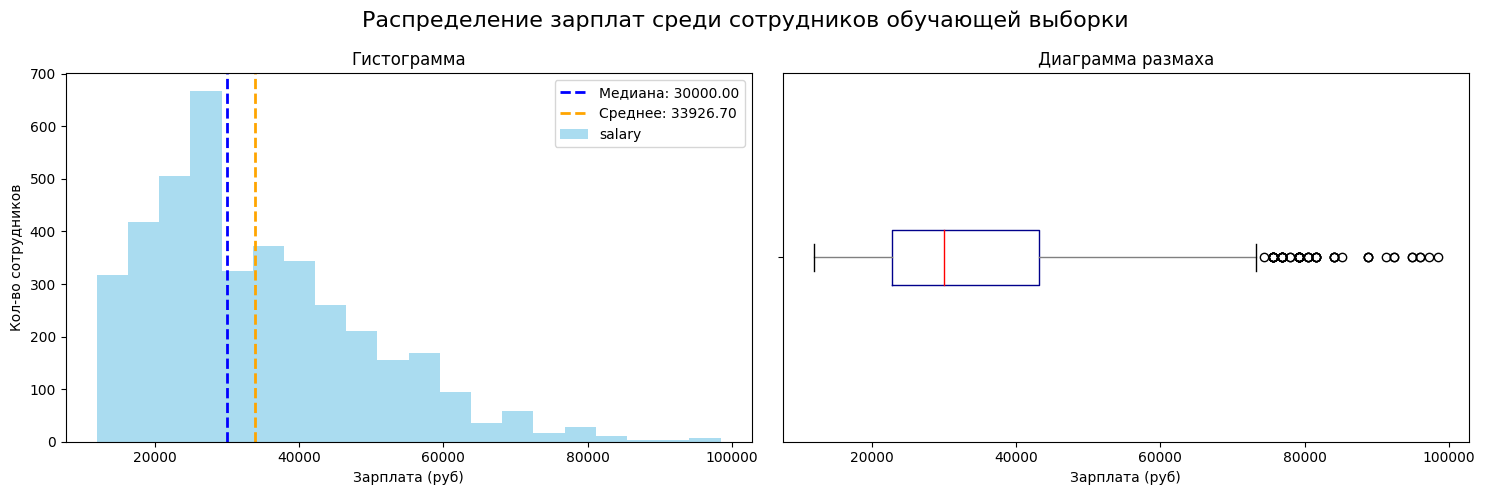

In [27]:
hist_and_box_chart(train_job_satisfaction_rate, 'salary', 'Распределение зарплат среди сотрудников обучающей выборки', 'Кол-во сотрудников', 'Зарплата (руб)', 20)

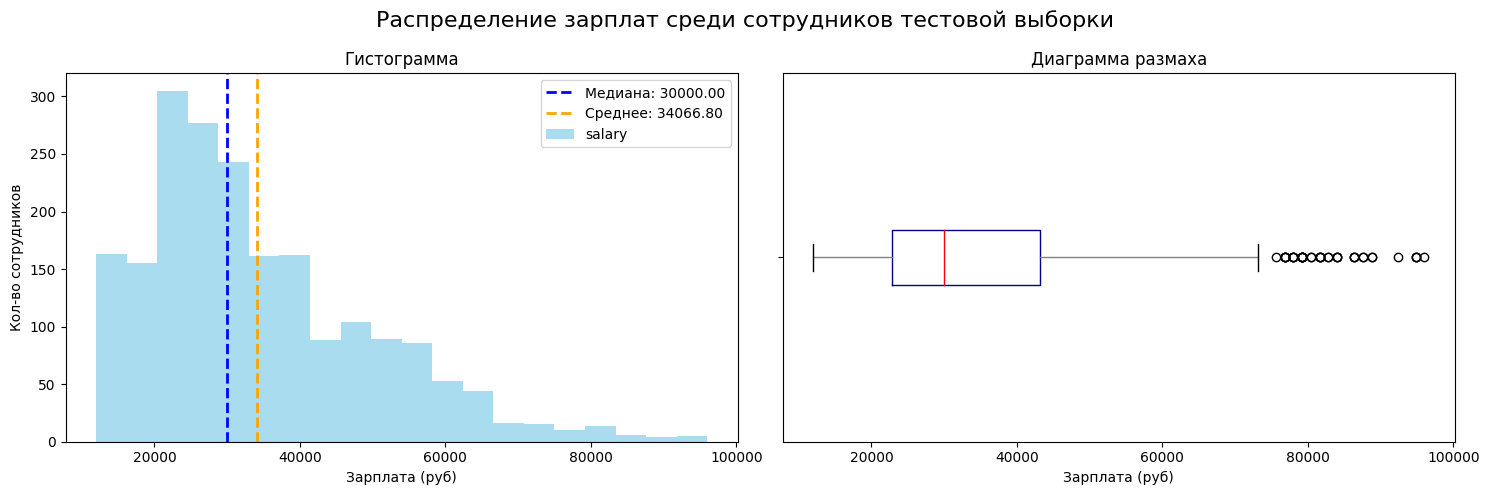

In [28]:
hist_and_box_chart(test_job_satisfaction_rate, 'salary', 'Распределение зарплат среди сотрудников тестовой выборки', 'Кол-во сотрудников', 'Зарплата (руб)', 20)

- Распределение в обучающей и тестовой выборках выглядят схоже, как и медианные и средние значения.
- Расределения имеют сильную правостороннюю ассиметрию: медианная зарплата 30 000, но хвост значений тянется почти до 100 000. 
- Большой разброс значений выглядит реалистично. Зарплата может зависеть от многих факторов: уровень сотрудника, отдел, стаж, индивидуальных договоров и т.д.
- На диаграммах размаха по обеим выборкам есть значения больше 70 000 выглядят, которые на выглядят как выбросы, но на деле являются логичным выражением многих дисбалансов среди сотрудников: малое число senior-специалистов, специалистов с большим стажем, т.д.

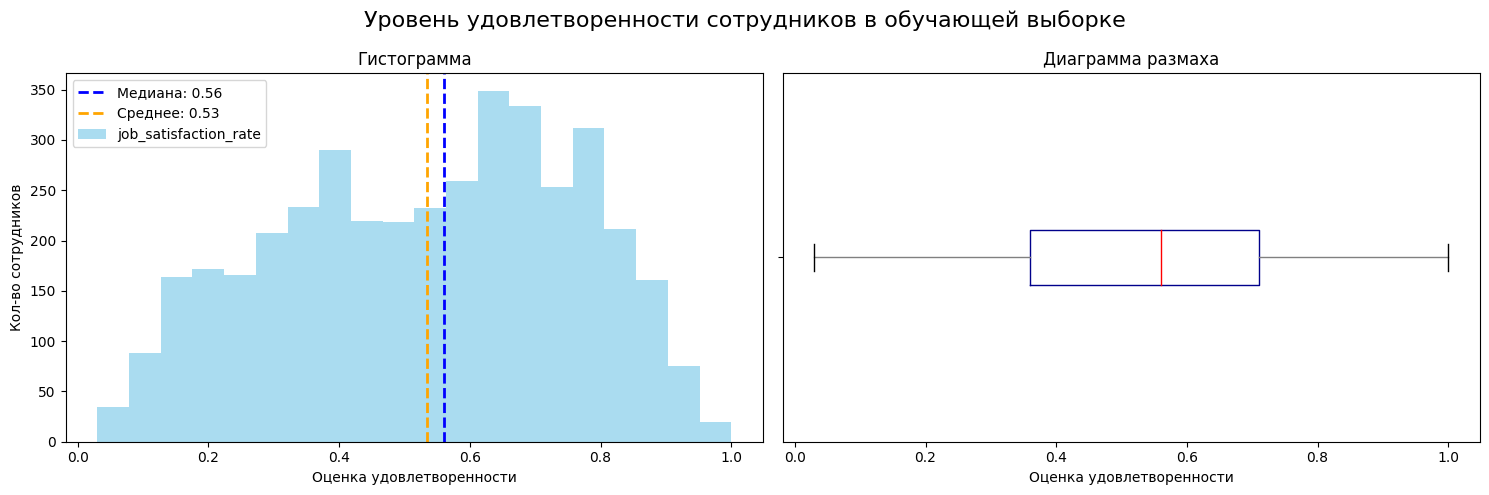

In [29]:
hist_and_box_chart(train_job_satisfaction_rate, 'job_satisfaction_rate', 'Уровень удовлетворенности сотрудников в обучающей выборке', 'Кол-во сотрудников', 'Оценка удовлетворенности', 20)

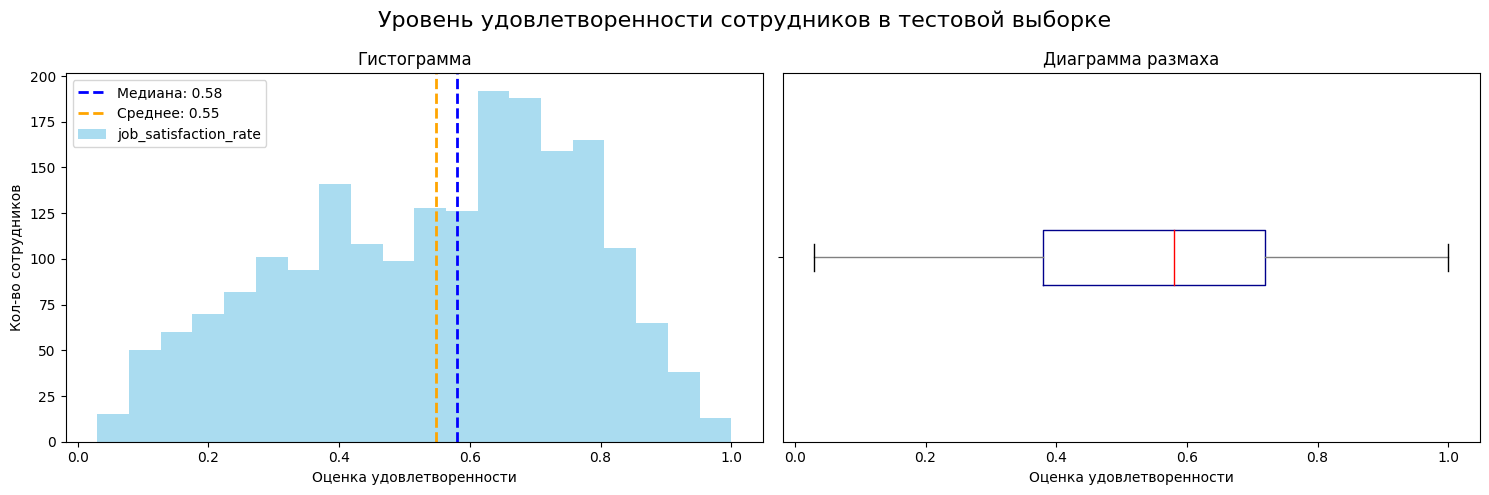

In [30]:
hist_and_box_chart(test_job_satisfaction_rate, 'job_satisfaction_rate', 'Уровень удовлетворенности сотрудников в тестовой выборке', 'Кол-во сотрудников', 'Оценка удовлетворенности', 20)

- Распределение в обучающей и тестовой выборках выглядят схоже, как и медианные и средние значения.
- График имеет левостороннюю ассиметрию: среднее и медиана чуть выше 0.5, и данные очень незначительно плотнее в "довольной" половине графика.
- Заметных аномалий нет.

#### Выводы по исследовательскому анализу

- Признаки в обучающих и тестовых данных выглядят в целом схоже: распределения, пропорции, средние и медианные значения очень похожи.
- В обеих выборках не обнаружено аномалий или неадекватных, неправдоподобных значений.

### Корреляционный анализ

#### Матрица корреляции

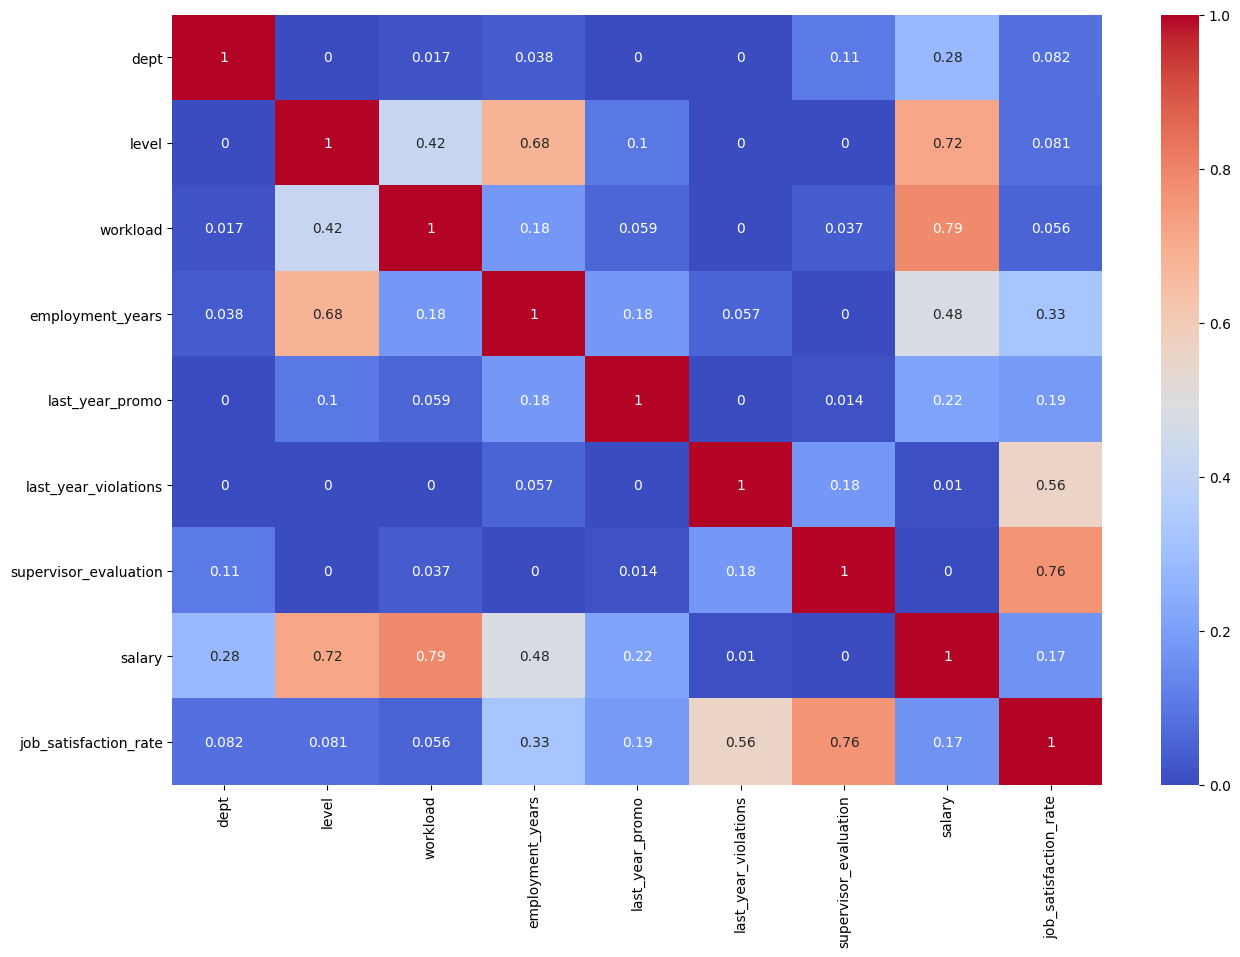

In [31]:
plt.figure(figsize=(15, 10))
#оценка руководителя по сути является ранговой переменной, поэтому в контексте вычисления корреляции признаков мы ее исключим из числа количественных
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate']
sns.heatmap(train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

- Сильнее всего уровень удовлетворенности коррелирует с оценкой руководства и наличием нарушений трудового контракта.
- Наблюдается выраженная мультиколинеарность в случае с зарплатой, загруженностью и уровнем квалификации сотрудника.

#### Выводы по корреляционному анализу

- Сильнее всего уровень удовлетоворения работой коррелирует с оценкой руководства и наличием нарушений трудового договора со стороны сотрудника.
- Мультиколинеарность устранять пока не будем - сначала посмотрим на результаты. Дереву решений она не страшна в принципе (она страшна мне - для интерпретации), а на показатели линейной регрессии надо посмотреть.

### Модель прогноза удовлетворенности

#### Создание пайплайна

Создадим модель обучения с учителем для задачи регрессии, целью которой является прогноз целевого признака - уровня удовлетворенности сотрудника. 
- Создадим пайплайн для теста 2 моделей: DecisionTreeRegressor(), LinearRegression().
- Применим метрику  SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).
- Проанализируем работу моделей.

In [32]:
#создаем выборки
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']


X_test = test_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_job_satisfaction_rate['job_satisfaction_rate']

#проверим соразмерность двух выборок
print('Размерность обучающих данных:', X_train.shape)
print('Размерность тестовых данных:', X_test.shape)

Размерность обучающих данных: (4000, 8)
Размерность тестовых данных: (2000, 8)


In [33]:
RANDOM_STATE = 30

smape_scorer = make_scorer(smape, greater_is_better=False)

#создаём списки с названиями признаков: категориальные, категориальные с "вшитым" делением на уровни и числовые признаки
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['supervisor_evaluation', 'level', 'workload']
num_columns = ['salary', 'employment_years']

#создаём пайплайн подготовки качественных признаков: заполнение пропусков, если вдруг такие случайно будут, и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
    )

#создаём пайплайн подготовки качественных признаков: заполнение пропусков, если они будут, Ordinal-кодирование со списком значений
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[[1, 2, 3, 4, 5],
                           ['junior', 'middle', 'senior'],
                           ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

#создаём общий пайплайн подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor())
])


param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']

    },
    

    # Словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }

]

#используем поиск по сетке, потому что желаем превратить Яндекс.Облако в Яндекс.Тучу
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print('Параметры лучшей модели:', grid_search.best_params_)
print('')
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Параметры лучшей модели: {'models': DecisionTreeRegressor(random_state=30), 'models__max_depth': 14, 'models__max_features': 12, 'preprocessor__num': MinMaxScaler()}

Метрика лучшей модели на тренировочной выборке: -14.756165022365266


In [34]:
#проверим модель на тестовой выборке
prediction = grid_search.predict(X_test)
print('Метрика лучшей модели на тестовой выборке:', smape(y_test, prediction))

Метрика лучшей модели на тестовой выборке: 14.153389802190697


#### Анализ работы модели

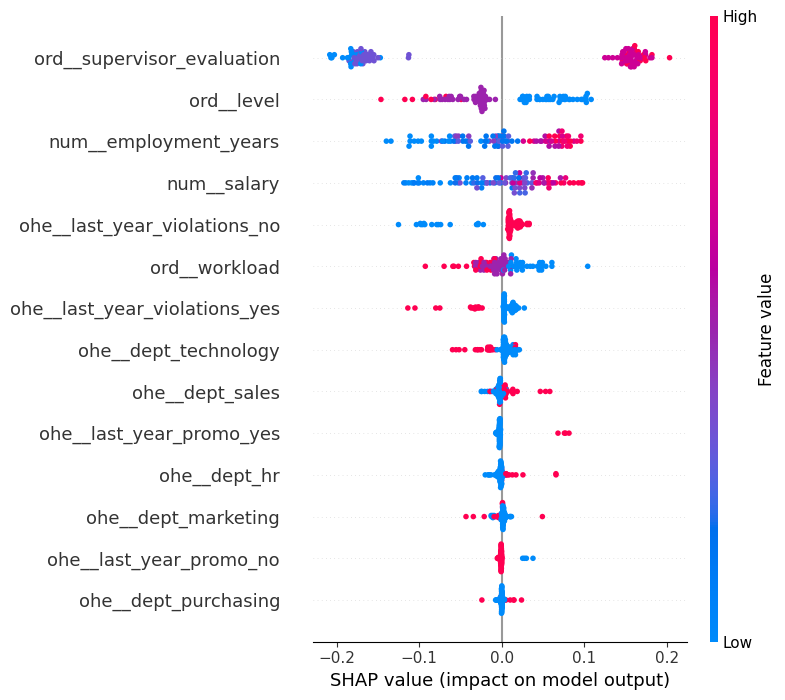

In [35]:
#извлекаем из пайплайна шаги
best_model_pipeline = grid_search.best_estimator_
preprocessor = best_model_pipeline.named_steps['preprocessor']
model = best_model_pipeline.named_steps['models']

#преобразуем выборку
X_train_sample = X_train.sample(100, random_state=RANDOM_STATE)
X_transformed = preprocessor.transform(X_train_sample)
feature_names = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

#создаем LinearExplainer и смотрим SHAP-значения
explainer = shap.Explainer(model, X_transformed_df)
shap_values = explainer(X_transformed_df)
shap.summary_plot(shap_values, X_transformed_df)

По SHAP-тесту удовлетворенность работой сильнее всего связана со следующими признаками:
- **Оценка руководителя**: высокая оценка работы от руководителя >> высокая удовлетворенность.
- **Уровень сотрудника**: низкий профессиональный уровень сотрудника >> высокая удовлетворенность.
- **Стаж работы**: большой стаж работы в компании >> высокая удовлетворенность.
- **Зарплата**: высокая зарплата >> высокая удовлетворенность.
- **Нарушения ТД**: отсутствие нарушений трудового договора >> высокая удовлетворенность.
- **Загруженность**: низкая загруженность >> высокая удовлетворенность.

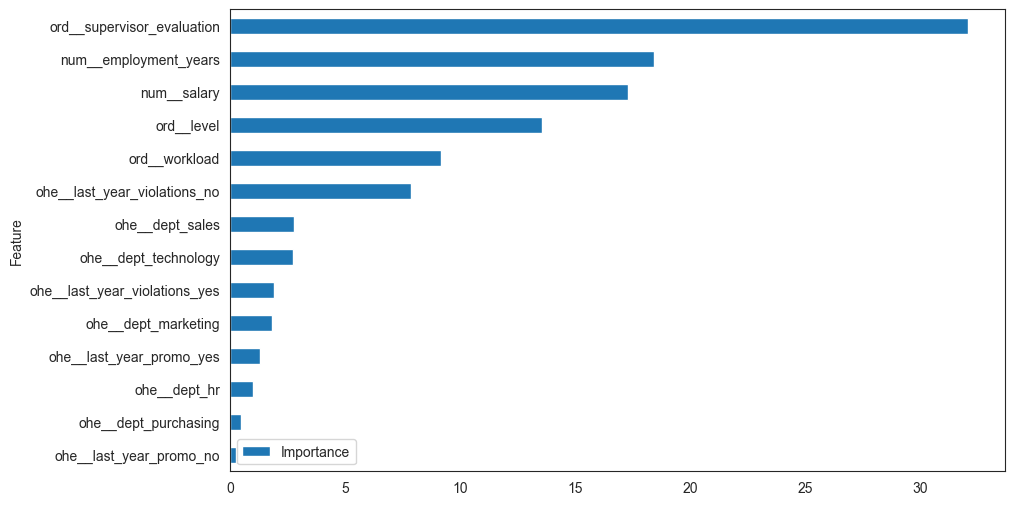

In [36]:
#создаем и преобразуем выборку
sample_for_pi = train_job_satisfaction_rate.drop(['id'], axis=1).sample(100, random_state=RANDOM_STATE)
X_sample_for_pi = sample_for_pi.drop('job_satisfaction_rate', axis=1)
y_sample_for_pi = sample_for_pi['job_satisfaction_rate']
X_for_pi_transformed = preprocessor.transform(X_sample_for_pi)
X_for_pi_transformed_df = pd.DataFrame(X_for_pi_transformed, columns=feature_names)

#проверяем значимость признаков с permutation_importance
result = permutation_importance(model, X_for_pi_transformed, y_sample_for_pi, scoring=smape_scorer)

#визуализируем
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

По тесту permutation_importance удовлетворенность работой сильнее всего связана со следующими признаками:
- **Оценка руководителя**
- **Стаж работы**
- **Зарплата**
- **Уровень сотрудника**
- **Отсутствие нарушений ТД**
- **Загруженность**

Рейтинг признаков практически идентичный SHAP-тесту.

#### Выводы по модели прогноза удовлетворенности

Лучше всех проявила себя модель Дерево решений - благодаря более эффективной работе с одинаково важными, хотя и коррелирующими между собой входными признаками, и большей гибкости в настройке гиперпараметров.
____

Выбранное Дерево решений имеет следующие характеристики: 
- max_depth=14
- max_features=12
- препроцессор числовых значений - MinMaxScaler.
_____

Метрика модели на тесте - 14.15.
____
  
Самыми важными признаками для прогноза удовлетворенности модели являются следующие:
- Оценка руководителя (высокая оценка >> высокая удовлетворенность)
- Стаж работы (большой стаж >> высокая удовлетворенность)
- Зарплата (высокая зарплата >> высокая удовлетворенность)
- Уровень сотрудника (низкий уровень >> высокая удовлетворенность)
- Отсутствие нарушений ТД
- Загруженность (низкая загруженность >> высокая удовлетворенность)



## Прогнозирование увольнения

### Предобработка данных

#### Импорт и обзор данных

In [37]:
#тестовые входные данные у нас уже загружены - это те же данные test_features
#импортируем обучающие данные для модели по прогнозу увольнения сотрудников и тестовые данные с целевым признаком
try:
    train_quit = pd.read_csv('Desktop/practicum cases/train_quit.csv')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

try:
    test_target_quit = pd.read_csv('Desktop/practicum cases/test_target_quit.csv')
except:
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [38]:
data_overview(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
562,568899,marketing,junior,medium,1,no,no,3,30000,yes
60,600907,sales,junior,medium,2,no,no,3,27600,no
3904,766909,sales,junior,medium,1,no,no,4,27600,no
3832,526614,technology,middle,medium,2,no,no,3,44400,no
1877,587707,marketing,middle,medium,6,no,no,4,36000,no
2057,972277,sales,middle,high,7,no,no,4,48000,yes
27,425551,technology,middle,medium,2,no,no,5,46800,no
785,172219,sales,sinior,high,9,no,no,3,63600,no
1327,366406,technology,junior,low,2,no,no,5,19200,no
2720,647029,marketing,junior,medium,1,no,no,4,31200,no



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [39]:
data_overview(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


,id,quit
418,554499,no
1519,652336,no
1511,811847,no
1532,771959,no
1813,331976,no
431,256367,no
1452,239527,no
24,939475,no
446,518361,no
767,860774,no



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


id      0
quit    0
dtype: int64

In [40]:
test_target_quit.nunique()

id      2000
quit       2
dtype: int64

**Итог обзора данных**

**train_quit**: данные по оттоку сотрудников для тренеровочной выборки 

- Названия столбцов ок.
- Проверить неявные дубликаты.
- Тип данных верный.
- Основные статистики выглядят адекватно.
- Пропущенных значений нет.
_____

**test_target_quit**: данные для теста с целевым значением - с данными по оттоку сотрудников
- Названия столбцов ок.
- Явных дубликатов нет, как и неявных - все id уникальные.
- Тип данных верный.
- Пропущенных значений нет.
_____

У **test_features** и **test_target_quit** сейчас разный порядок id, что создаст в дальнейшем сложности для сверки предсказания и истинного значения.
Для уменьшения путаницы и числа сущностей мы объединим **test_target_quit** с таблицей **test_job_satisfaction_rate**, где есть входные признаки тестовой выборки (**test_features**), включая уровень удовлетворенности сотрудников (**test_target_job_satisfaction_rate**).

#### Проверка на неявные дубликаты

In [41]:
#проверим наличие опечаток или других погрешностей, в которых могли скрыться неявные дубликаты
print('Число уникальных id:', train_quit['id'].nunique())
print('')
print(train_quit['dept'].value_counts())
print('')
print(train_quit['level'].value_counts())
print('')
print(train_quit['workload'].value_counts())
print('')
print(train_quit['last_year_promo'].value_counts())
print('')
print(train_quit['last_year_violations'].value_counts())
print('')
print(train_quit['quit'].value_counts())
print('')

Число уникальных id: 4000

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

medium    2118
low       1208
high       674
Name: workload, dtype: int64

no     3887
yes     113
Name: last_year_promo, dtype: int64

no     3455
yes     545
Name: last_year_violations, dtype: int64

no     2872
yes    1128
Name: quit, dtype: int64



- Значения в целом корректные и уникальные, неявным дубликатам тут быть негде.
- Заменим sinior на senior, потому что бесит.

In [42]:
#заменим и проверим значения в колонке
train_quit.loc[train_quit['level'] == 'sinior', 'level'] = 'senior'
train_quit['level'].value_counts()

junior    1949
middle    1694
senior     357
Name: level, dtype: int64

In [43]:
#и еще раз проверим на дубликаты, чисто для души
print('Кол-во явных дубликатов:', train_job_satisfaction_rate.duplicated().sum())

Кол-во явных дубликатов: 0


#### Объединение тестовой выборки

In [44]:
#объединим выборки для удобства и тотальности совпадения данных
test_quit=pd.merge(test_job_satisfaction_rate, test_target_quit, on='id', how='inner')
data_overview(test_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no
5,429973,purchasing,middle,medium,6,no,no,3,42000,0.67,yes
6,850699,technology,junior,medium,3,no,no,3,26400,0.36,yes
7,500791,sales,middle,high,9,no,no,4,49200,0.73,no
8,767867,marketing,middle,high,3,no,yes,4,62400,0.44,no
9,937235,sales,junior,medium,1,no,yes,3,26400,0.22,yes


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
430,363400,hr,middle,high,3,yes,yes,3,49200,0.32,no
1544,293023,sales,junior,medium,2,no,no,5,27600,0.76,no
1302,289723,technology,junior,low,1,no,no,3,15600,0.10,yes
1037,368424,marketing,junior,medium,1,no,no,2,30000,0.31,yes
147,270617,marketing,middle,low,2,no,no,4,31200,0.69,no
666,735493,purchasing,junior,medium,2,no,no,4,28800,0.93,no
1220,535196,hr,junior,low,2,no,no,4,20400,0.75,no
448,339265,sales,junior,low,1,no,no,1,18000,0.27,yes
677,630393,sales,middle,low,2,no,no,5,28800,0.68,no
980,521799,sales,middle,medium,7,no,yes,1,37200,0.17,no



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
employment_years,2000.0,3.66650,2.537222,1.00,1.00,3.00,6.00,10.0
supervisor_evaluation,2000.0,3.52650,0.996892,1.00,3.00,4.00,4.00,5.0
salary,2000.0,34066.80000,15398.436729,12000.00,22800.00,30000.00,43200.00,96000.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
quit                     0
dtype: int64

- Объединенный файл содержит 2000 id.
- Объединенный файл сохранил все нужные характеристики оригинальных файлов: верный тип данных, отсутствие любых дубликатов, пропуски в dept и level.

#### Дополнение обучающей выборки

Для дальнейшего исследования нам также понадобятся данные по удовлетворенности сотрудников, в т.ч. сотрудников из обучающей выборки - чтобы в рамках исследовательского анализа сравнить этот показатель с распределением в тестовой выборке, а также проверить теорию о связи увольнения и низкой удовлетворенности.
Добавим к обучающей выборке оценочное значение с помощью обученной модели.

In [45]:
train_quit['job_satisfaction_rate'] = grid_search.predict(train_quit)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.601667
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.822093
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.540000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


#### Выводы по предобработке

**train_quit**: данные с оценкой уровня удовлетворенности сотрудников для тренеровочной выборки 

- Названия столбцов и тип данных ок.
- Дубликатов нет, явных и неявных.
- Заменили в столбце 'level' значения 'sinior' на 'senior'.
- Был добавлен признак 'job_satisfaction_rate_prediction' на основе обученной модели.
- Основные статистики выглядят адекватно.
- Пропущенных значений нет.
____

**test_quit**: данные об увольнении сотрудников и их характеристиками для тестовой выборки (включая оценку уровня удовлетворенности сотрудников).

Файл был получен из объединения **test_target_quit** и **test_job_satisfaction_rate** (**test_features** + **test_target_job_satisfaction_rate**), чтобы не было путаницы в id и файлах в принципе.

- Названия столбцов и тип данных ок.
- Дубликатов нет, явных и неявных.
- Основные статистики выглядят адекватно.
- Пропущенные значения: 2 в столбце debt и 1 в столбце level. Их мы заполним при создании пайплайна. 



### Исследовательский анализ

#### Категориальные признаки

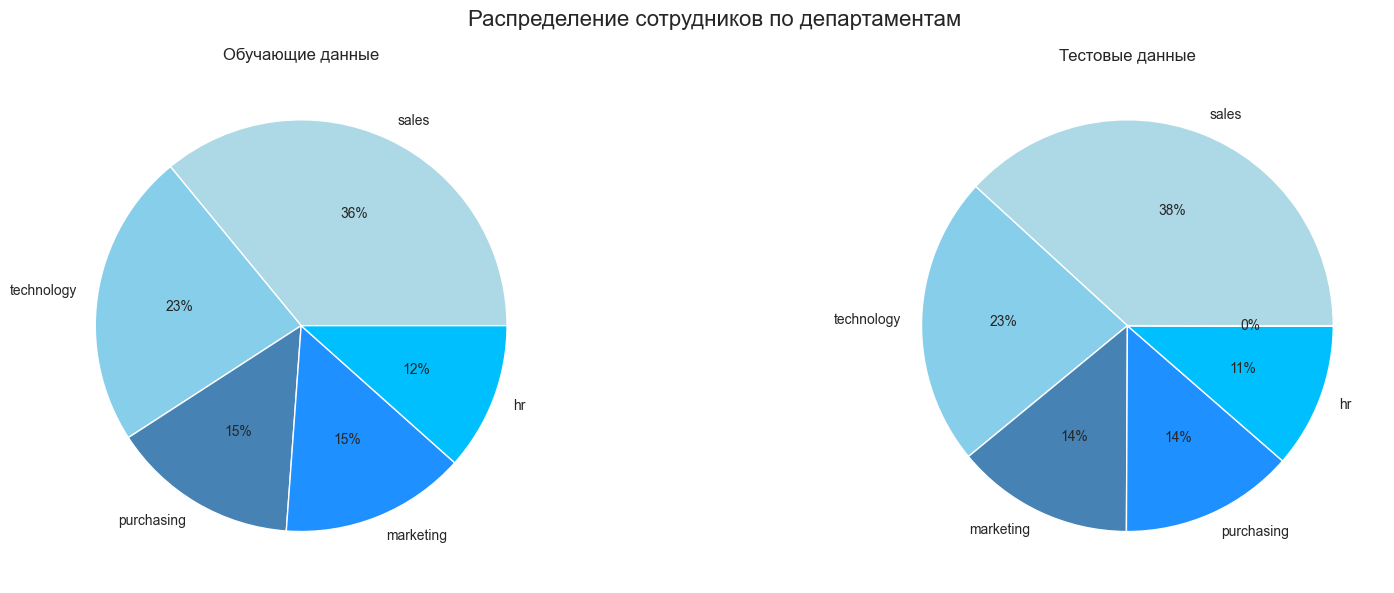

In [46]:
cutie_pie_chart_for_two(train_quit, test_quit, 'dept', 'Распределение сотрудников по департаментам')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Большая часть сотрудников работают в отделе продаж.
- Меньше всего сотрудников в отделе HR.
- Распределение несколько неравномерное, но выглядит достоверно, не противоречит здравому смыслу и реальности.

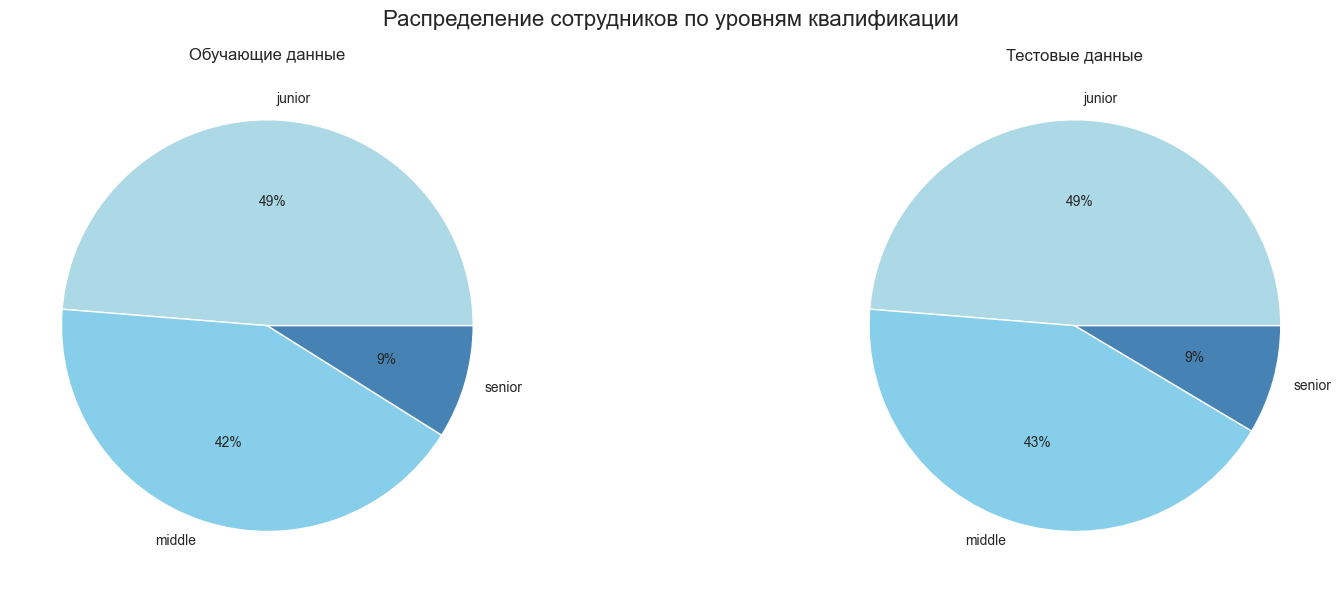

In [47]:
cutie_pie_chart_for_two(train_quit, test_quit, 'level', 'Распределение сотрудников по уровням квалификации')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Cтарших сотрудников в компании меньше всего, меньше 10%.
- Основная масса сотрудников имеют уровни junior и middle - приблизительно равное число.
- Диспропорция сильная, но более чем реалистичная.

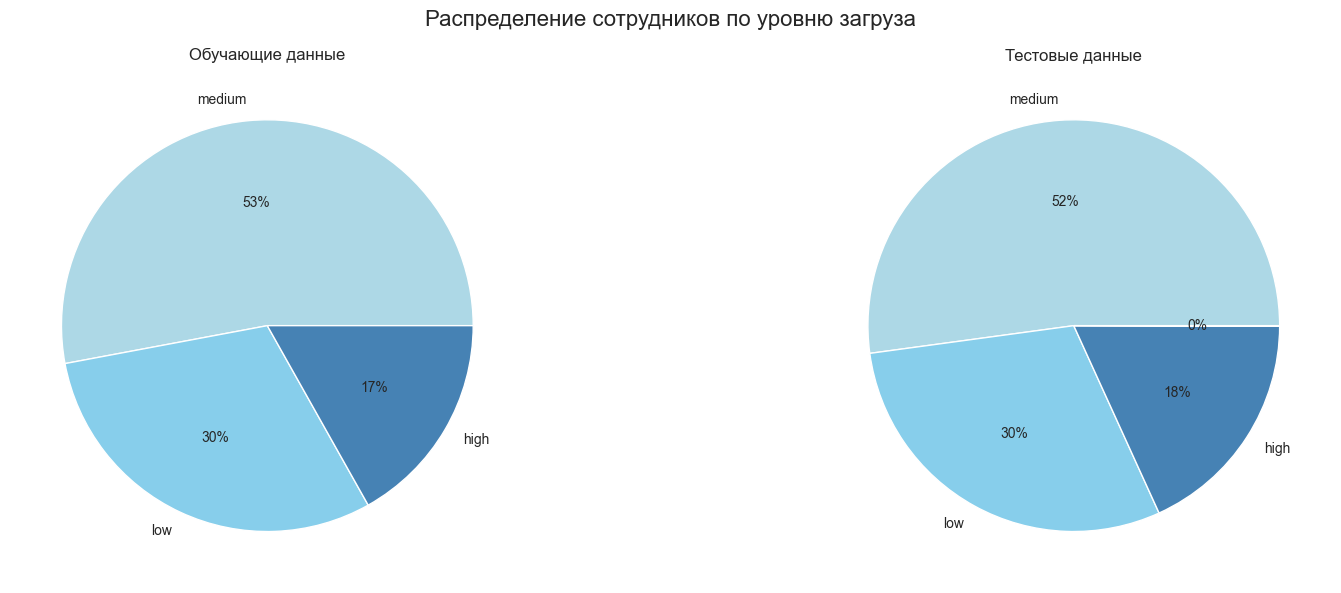

In [48]:
cutie_pie_chart_for_two(train_quit, test_quit, 'workload', 'Распределение сотрудников по уровню загруза')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Чуть больше половины сотрудников имеют умеренный уровень загруженности.
- Самая малочисленную категорию составляют люди с высоким уровнем загруженности.
- Распределение неравномерное, но реалистичное.

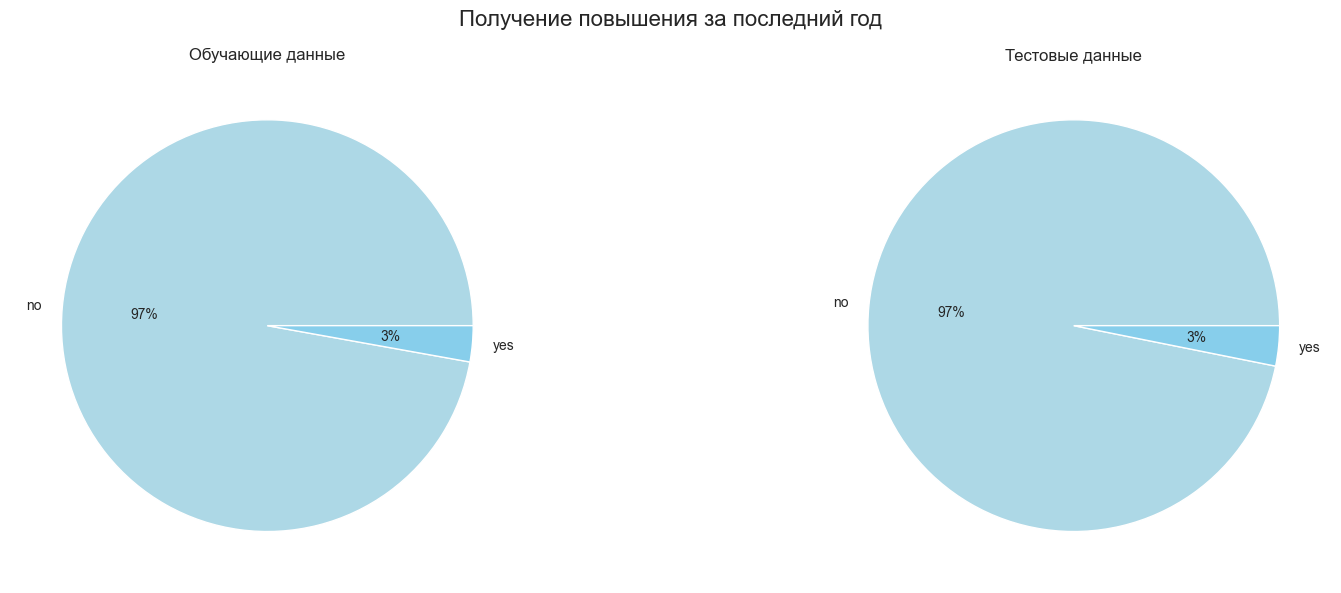

In [49]:
cutie_pie_chart_for_two(train_quit, test_quit, 'last_year_promo', 'Получение повышения за последний год')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Очень сильная диспропорция: только у 3% сотрудников было повышение за последний год.
- Сложно судить, насколько эта ситуация адекватна: это может быть как нормальный % повышений для компании, так и результатом плохого финансового года, например.

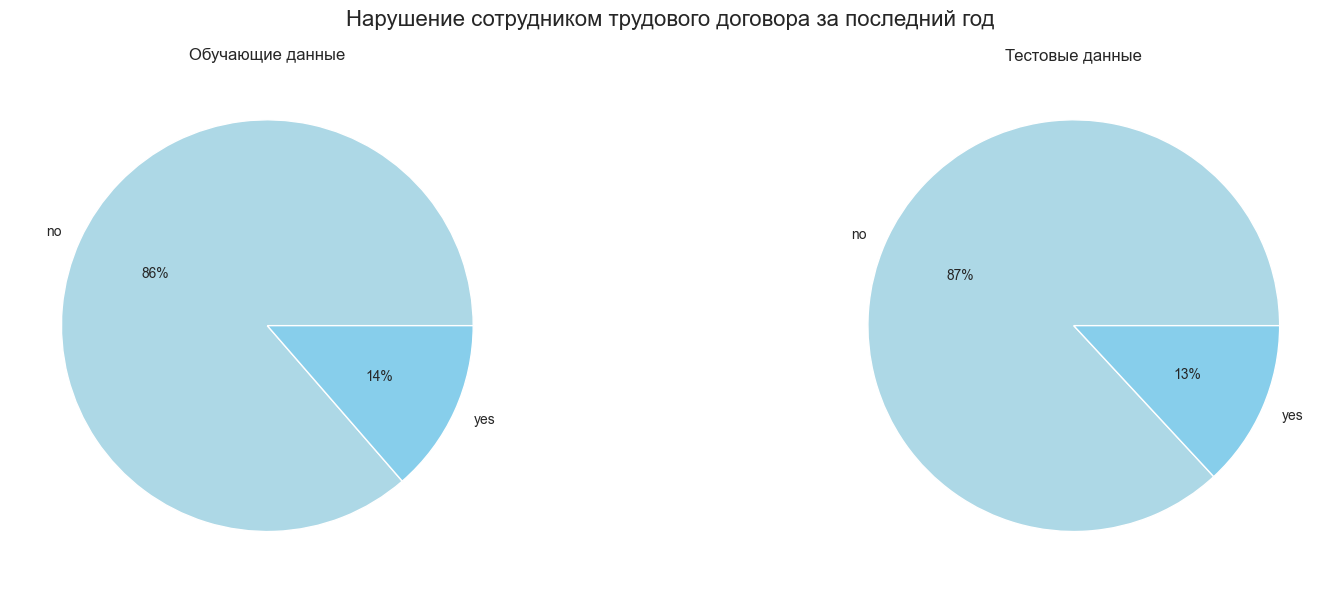

In [50]:
cutie_pie_chart_for_two(train_quit, test_quit, 'last_year_violations', 'Нарушение сотрудником трудового договора за последний год')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Большая часть сотрудников не имеет фиксированных нарушений.
- Диспропорция заметная, но скорее реалистичная, правдоподобная.

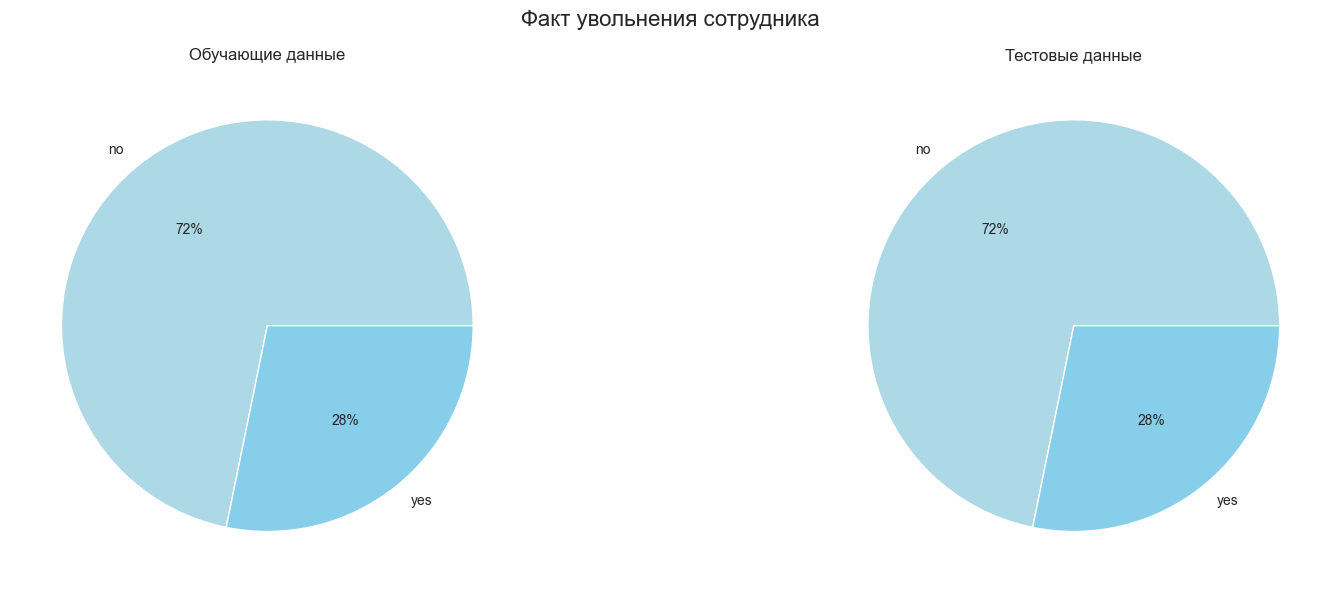

In [51]:
cutie_pie_chart_for_two(train_quit, test_quit, 'quit', 'Факт увольнения сотрудника')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Увольняется приблизительно каждый третий. Диспропорция выглядит в целом правдоподобно.
- Диспропорция 1 к 2 заметная, но не критичная. Синтетические дополнения для выравнивания в данном случае скорее исказят картину, чем сделают прогноз достовернее.


#### Количественные признаки

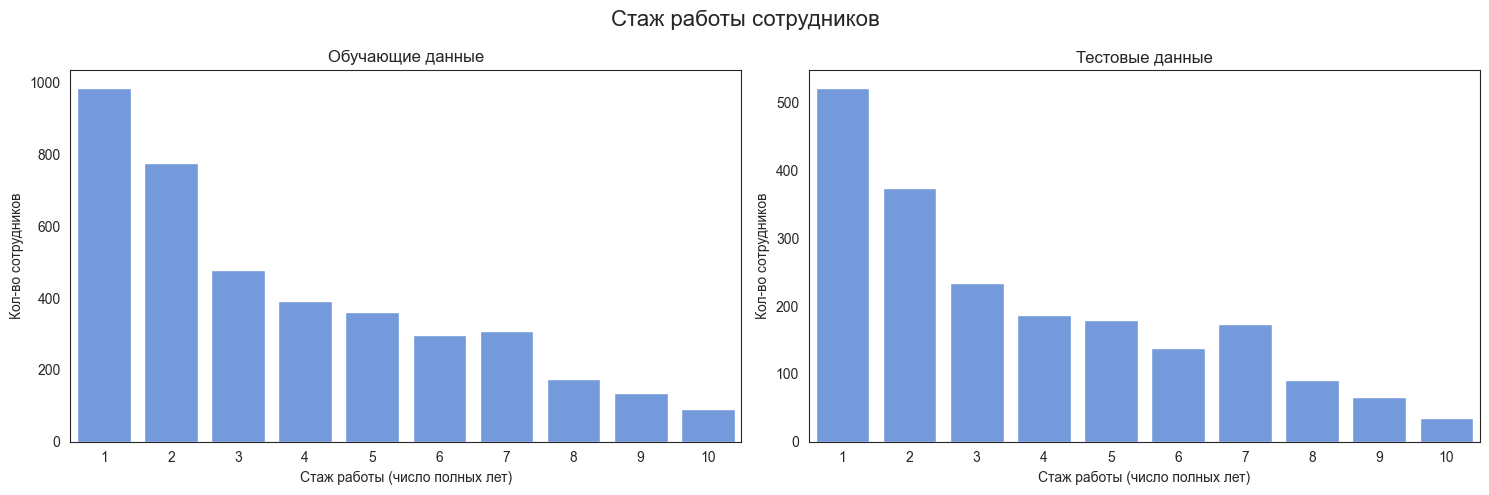

In [52]:
countplot_for_two(train_quit, test_quit, 'employment_years', 'Стаж работы сотрудников', 'Кол-во сотрудников', 'Стаж работы (число полных лет)')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Половина сотрудников компании имеют стаж в компании не больше 3 лет.
- Дальше значения тем реже, чем они больше (за редким исключением).
- В целом ситуация адекватная, правдоподобная.

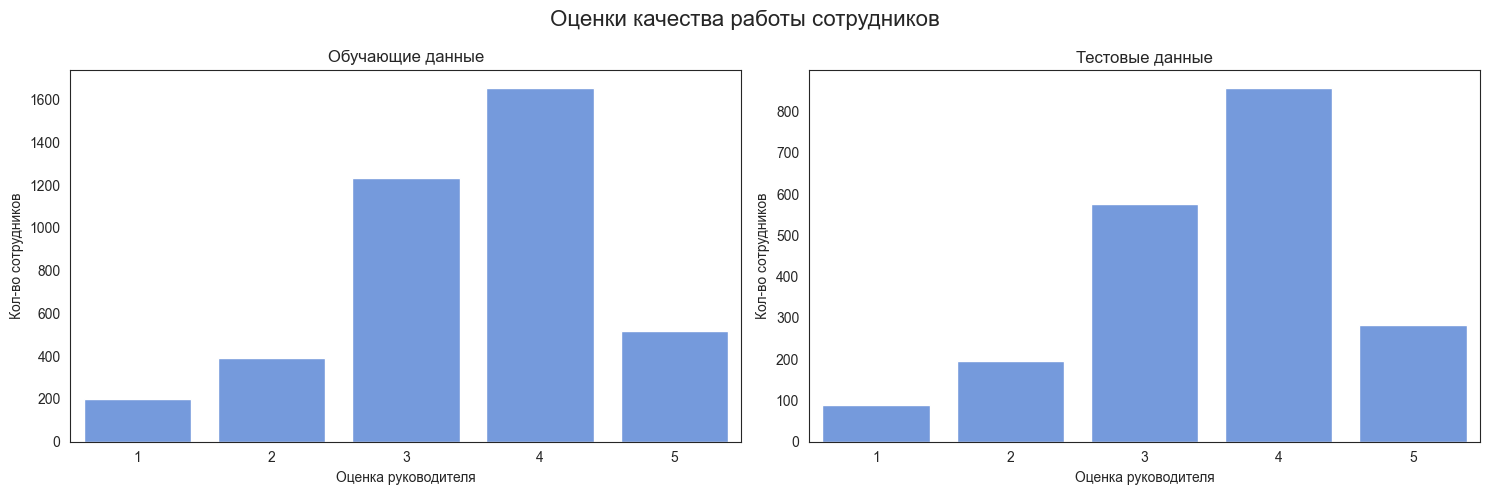

In [53]:
countplot_for_two(train_quit, test_quit, 'supervisor_evaluation', 'Оценки качества работы сотрудников', 'Кол-во сотрудников', 'Оценка руководителя')

- Распределение в обучающей и тестовой выборках выглядят схоже.
- Большинство сотрудников имеют оценки работы 3 и 4.
- Очень низких значений (2 и 1) почти столько же, сколько очень высоких (5).
- В целом и обилие средних оценок и редкость очень плохих оценок выглядят правдоподобно - очень плохих сотрудников и не может быть много, тогда бы плохой результат был нормальным, т.е. средним.

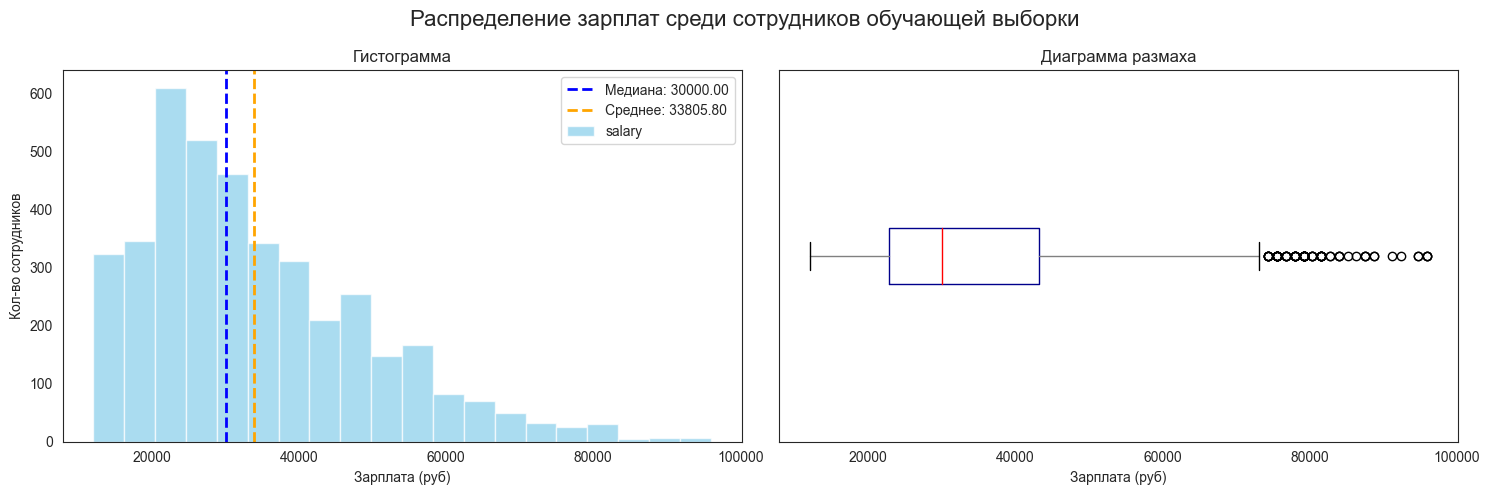

In [54]:
hist_and_box_chart(train_quit, 'salary', 'Распределение зарплат среди сотрудников обучающей выборки', 'Кол-во сотрудников', 'Зарплата (руб)', 20)

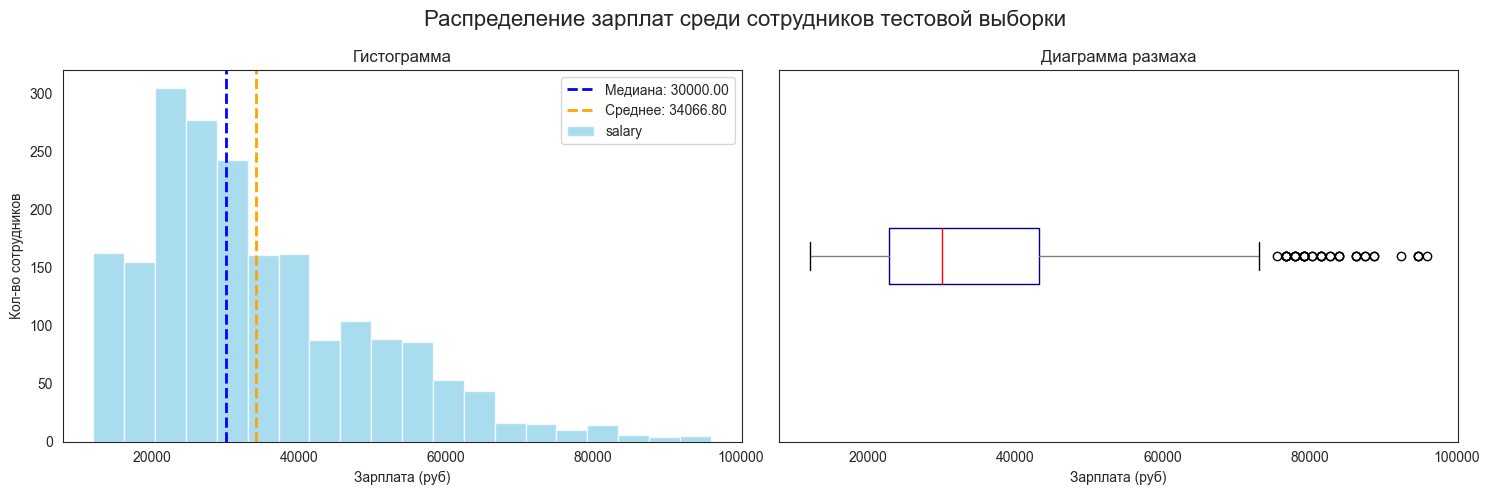

In [55]:
hist_and_box_chart(test_quit, 'salary', 'Распределение зарплат среди сотрудников тестовой выборки', 'Кол-во сотрудников', 'Зарплата (руб)', 20)

- Распределение в обучающей и тестовой выборках выглядят схоже, как и медианные и средние значения.
- Расределения имеют сильную правостороннюю ассиметрию: медианная зарплата 30 000, но хвост значений тянется почти до 100 000. 
- Большой разброс значений выглядит реалистично. Зарплата может зависеть от многих факторов: уровень сотрудника, отдел, стаж, индивидуальных договоров и т.д.
- На диаграммах размаха по обеим выборкам есть значения больше 70 000 выглядят, которые на выглядят как выбросы, но на деле являются логичным выражением многих дисбалансов среди сотрудников: малое число senior-специалистов, специалистов с большим стажем, т.д.

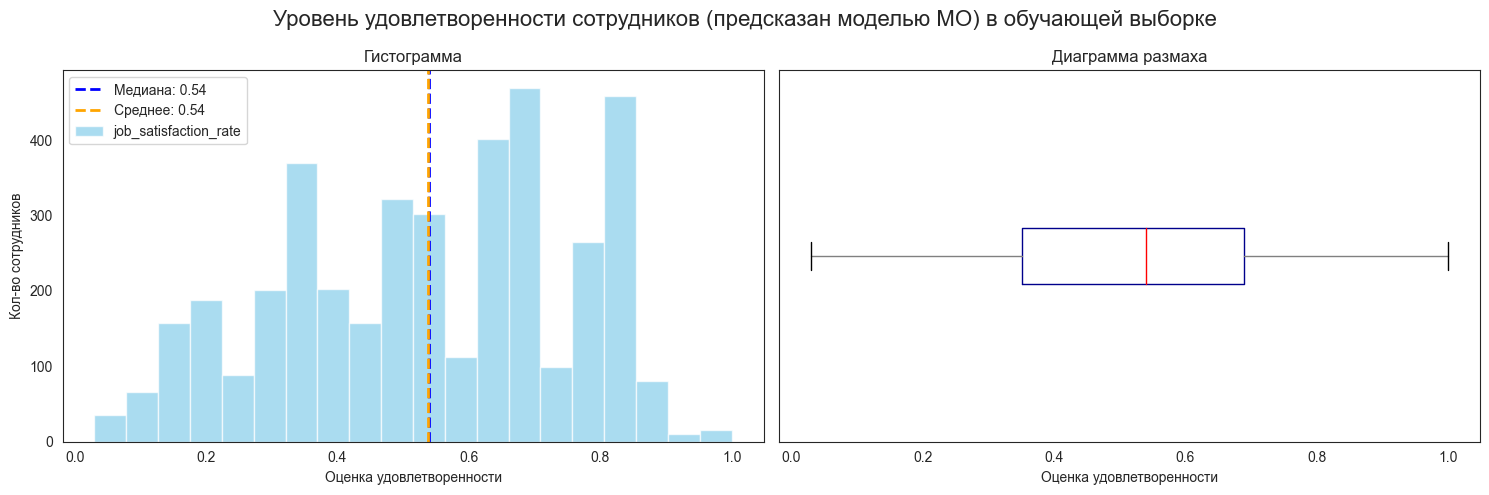

In [56]:
hist_and_box_chart(train_quit, 'job_satisfaction_rate', 'Уровень удовлетворенности сотрудников (предсказан моделью МО) в обучающей выборке', 'Кол-во сотрудников', 'Оценка удовлетворенности', 20)

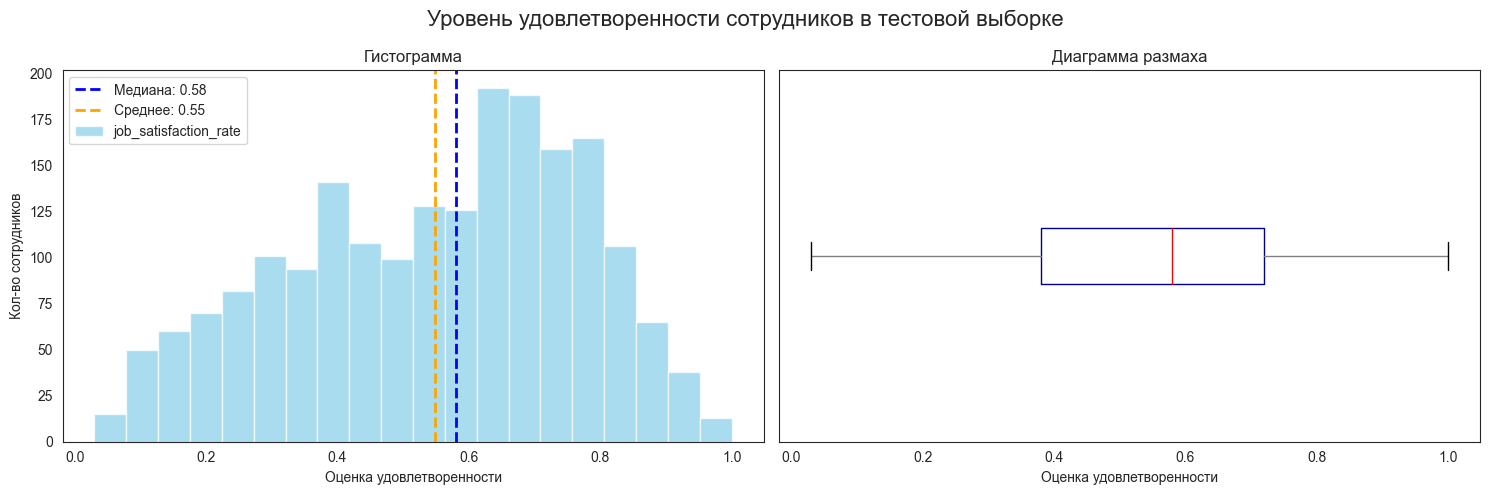

In [57]:
hist_and_box_chart(test_quit, 'job_satisfaction_rate', 'Уровень удовлетворенности сотрудников в тестовой выборке', 'Кол-во сотрудников', 'Оценка удовлетворенности', 20)

- Распределение в обучающей и тестовой выборках выглядят схоже, как и медианные и средние значения.
- График имеет левостороннюю ассиметрию: среднее и медиана чуть выше 0.5, и данные очень незначительно плотнее в "довольной" половине графика.
- Заметных аномалий нет.

### Описание типичного уволившегося сотрудника

#### Распределение признаков в контексте увольнения

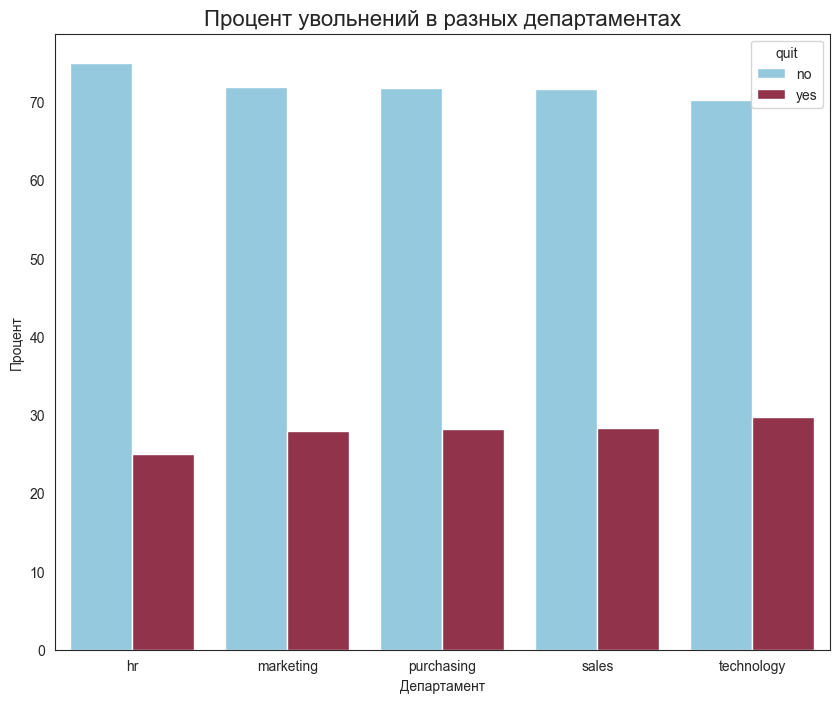

In [58]:
quit_percent_plot('dept', 'Процент увольнений в разных департаментах', 'Департамент')

- В разных отделах в целом сохраняется соотношение 1 к 2.
- Чуть реже обычного увольняются в департаменте hr. Чуть чаще - в техническом.

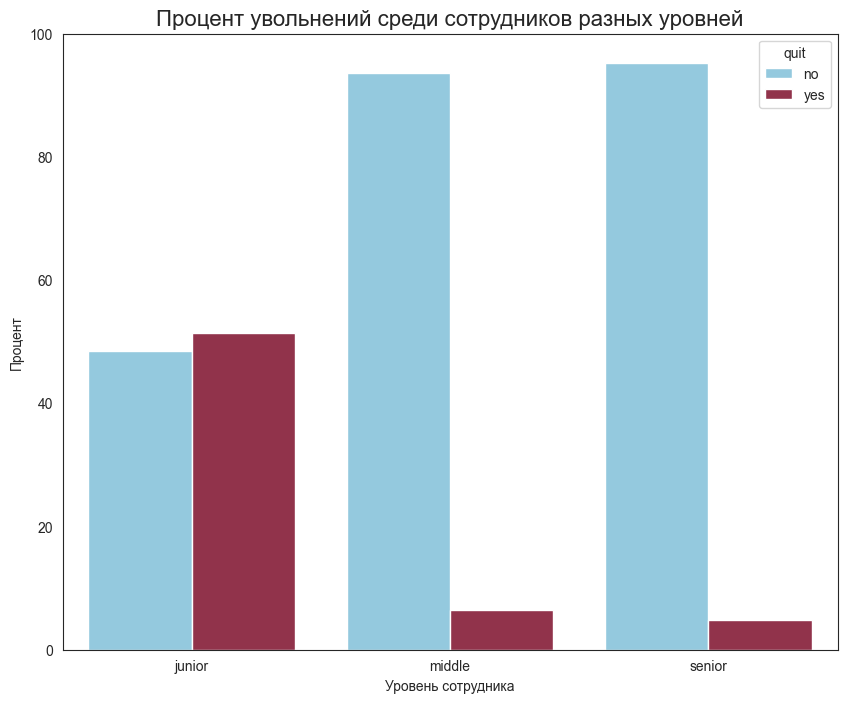

In [59]:
quit_percent_plot('level', 'Процент увольнений среди сотрудников разных уровней', 'Уровень сотрудника')

- Больше половины сотрудников уровня junior увольняются.
- Среди сотрудников уровня middle и senior увольнения очень редки. 

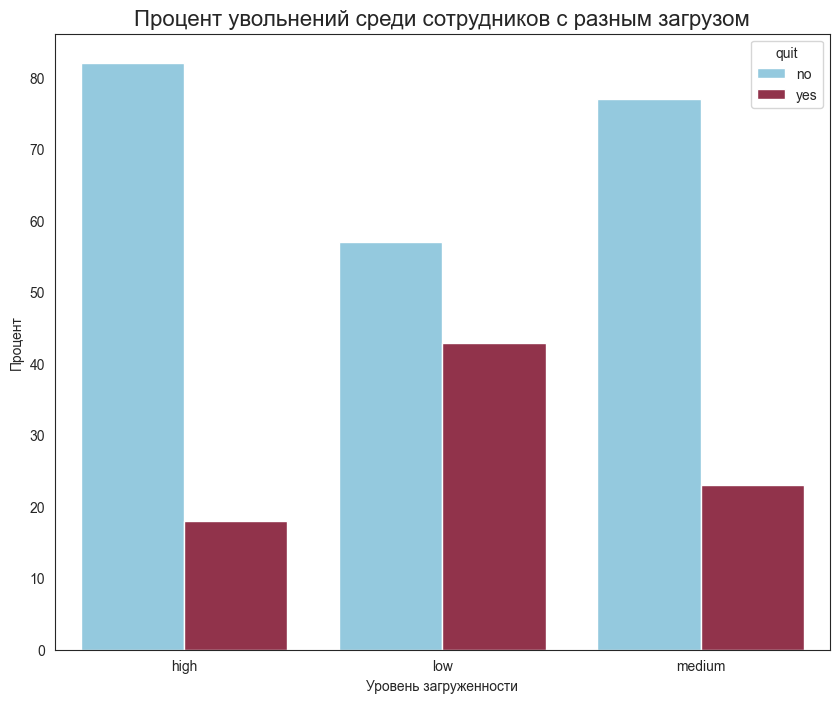

In [60]:
quit_percent_plot('workload', 'Процент увольнений среди сотрудников с разным загрузом', 'Уровень загруженности')

- Чуть меньше половины уволившихся сотрудников - сотрудники с низким уровнем загруженности.
- Реже всего увольняются сотрудники с высоким уровнем загруженности.

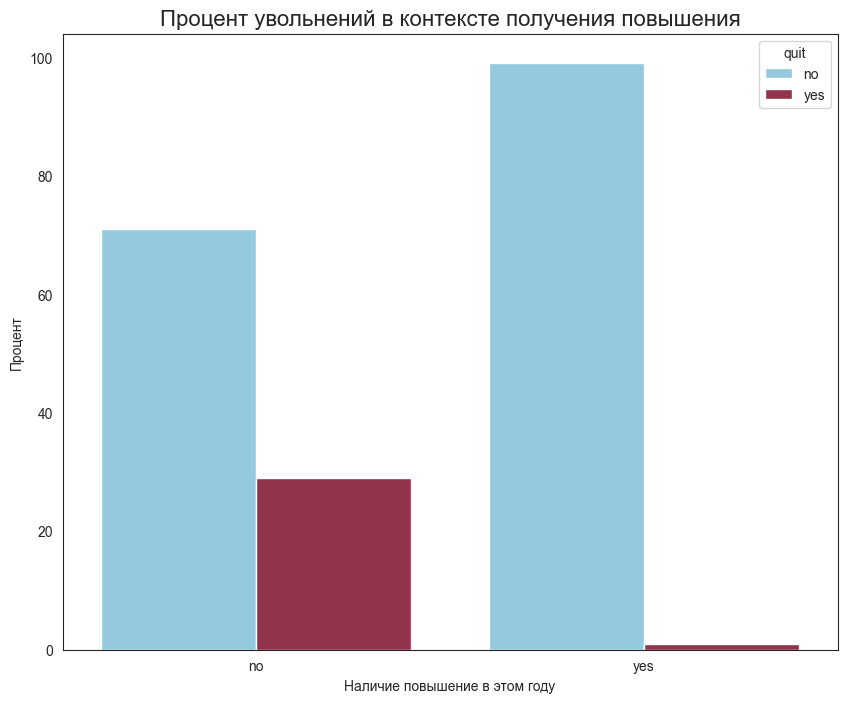

In [61]:
quit_percent_plot('last_year_promo', 'Процент увольнений в контексте получения повышения', 'Наличие повышение в этом году')

- Значительно чаще увольняются сотрудники, которые не получили повышение (но тут надо помнить, что получивших повышение - всего 3%)

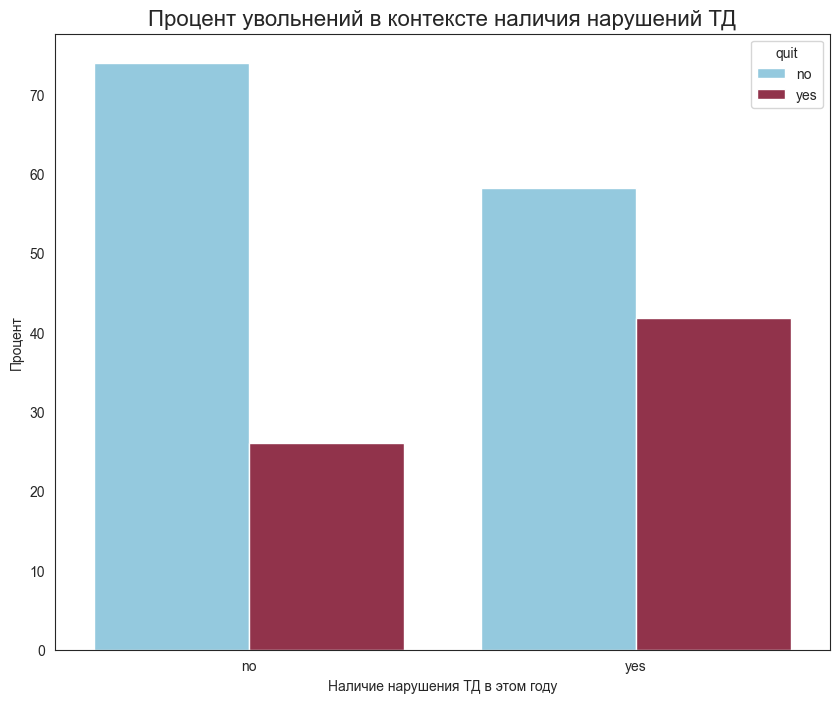

In [62]:
quit_percent_plot('last_year_violations', 'Процент увольнений в контексте наличия нарушений ТД', 'Наличие нарушения ТД в этом году')

- Больше, чем в 40% случаев, сотрудники, совершившие нарушение ТД, увольняются.

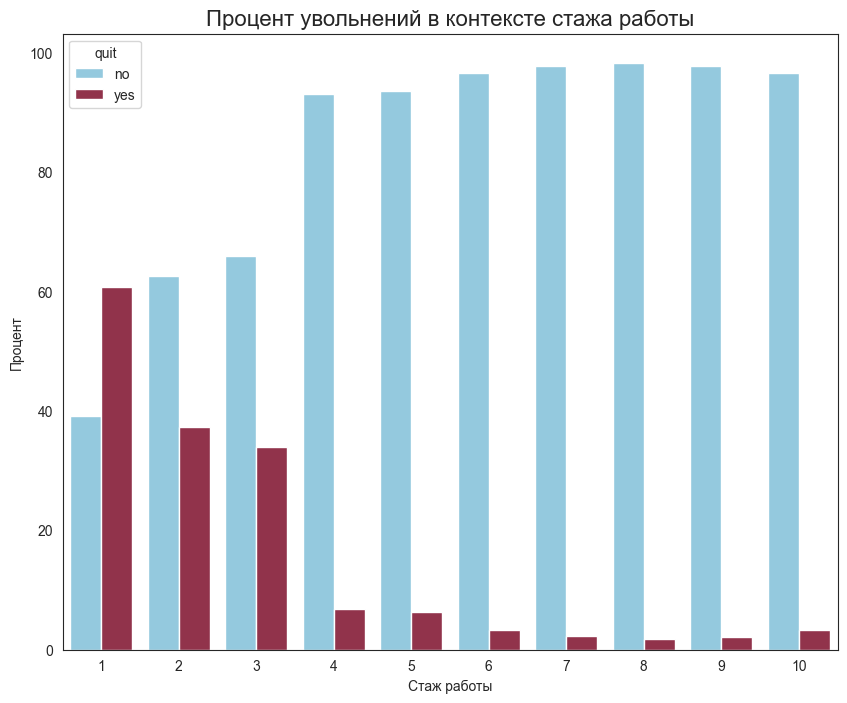

In [63]:
quit_percent_plot('employment_years', 'Процент увольнений в контексте стажа работы', 'Стаж работы')

- В первый год работы почти 2/3 сотрудников увольняются.
- Чаще всего люди увольняются в первые 3 года работы.
- Число увольнений резко снижается на 4 год работы (приблизительно в 5 раз).

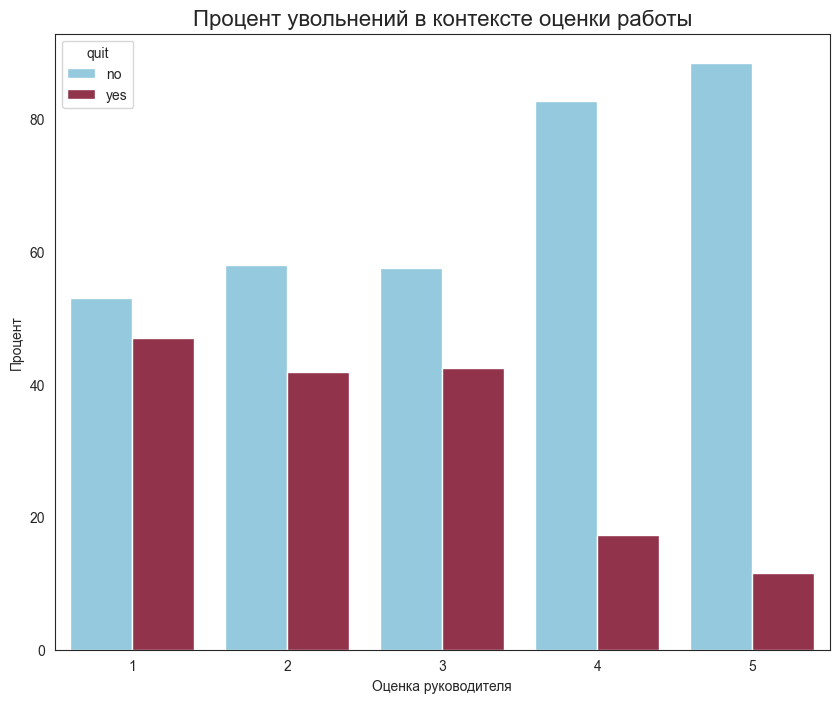

In [64]:
quit_percent_plot('supervisor_evaluation', 'Процент увольнений в контексте оценки работы', 'Оценка руководителя')

- Сотрудники с оценкой от 1 до 3 увольняются в 40% случаев.
- Оценки 4 и 5 резко повышают лояльность сотрудника.

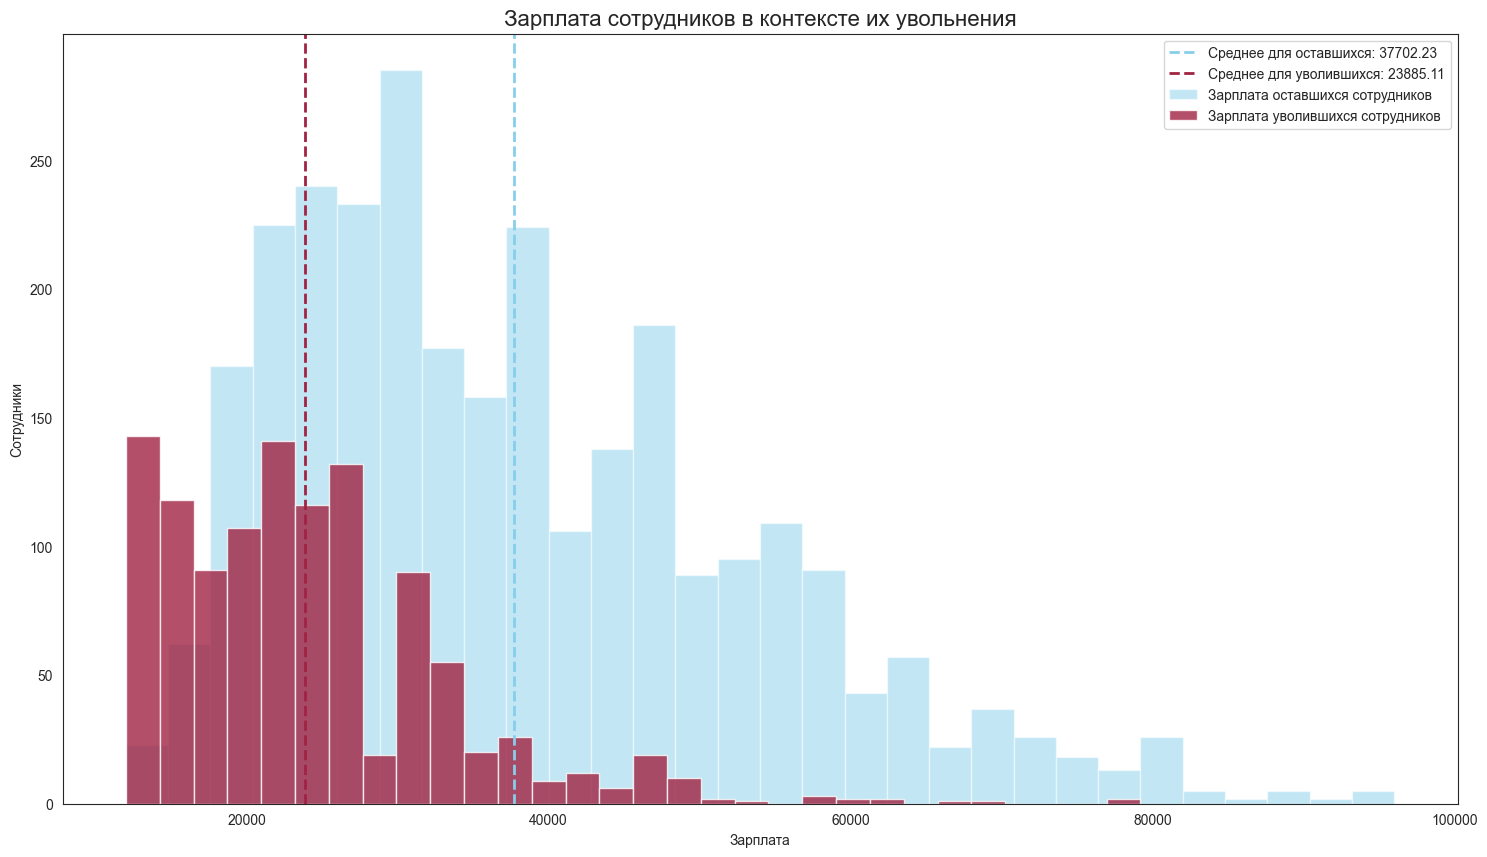

In [65]:
plt.figure(figsize=(18, 10))

#строим гистограммы доходов сотрудников
train_quit.query('quit == "no"')['salary'].hist(
    bins=30, alpha=0.5, 
    label='Зарплата оставшихся сотрудников', 
    color='#87CEEB', grid=False)
train_quit.query('quit == "yes"')['salary'].hist(
    bins=30, alpha=0.8, 
    label='Зарплата уволившихся сотрудников', 
    color='#A12343', grid=False)

#отметим среднюю зп
mean_quit = train_quit.query('quit == "yes"')['salary'].mean()
mean_stay = train_quit.query('quit == "no"')['salary'].mean()
plt.axvline(mean_stay, color='#87CEEB', linestyle='dashed', linewidth=2, 
            label=f'Среднее для оставшихся: {mean_stay:.2f}')
plt.axvline(mean_quit, color='#A12343', linestyle='dashed', linewidth=2, 
            label=f'Среднее для уволившихся: {mean_quit:.2f}')


plt.title('Зарплата сотрудников в контексте их увольнения', fontsize=16)
plt.ylabel('Сотрудники')
plt.xlabel('Зарплата')

plt.legend()

plt.show()

- Зарплата уволившихся сотрудников была в среднем заметно ниже - ниже и среднего среди всех, и средней среди оставшихся сотрудников.

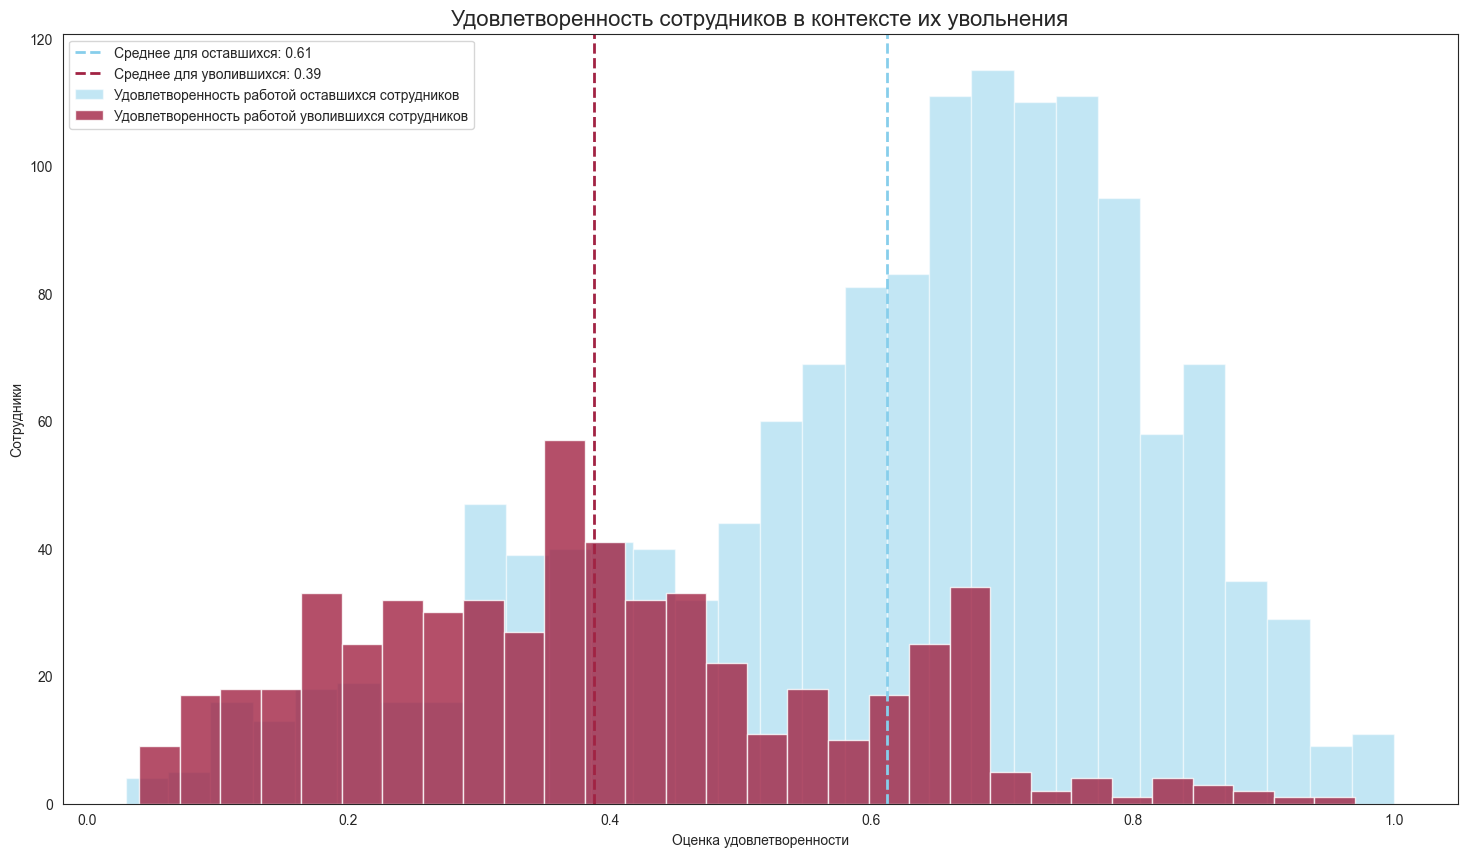

In [66]:
plt.figure(figsize=(18, 10))

#строим гистограммы доходов сотрудников
test_quit.query('quit == "no"')['job_satisfaction_rate'].hist(
    bins=30, alpha=0.5, 
    label='Удовлетворенность работой оставшихся сотрудников', 
    color='#87CEEB', grid=False)
test_quit.query('quit == "yes"')['job_satisfaction_rate'].hist(
    bins=30, alpha=0.8, 
    label='Удовлетворенность работой уволившихся сотрудников', 
    color='#A12343', grid=False)

#отметим среднюю зп
mean_quit = test_quit.query('quit == "yes"')['job_satisfaction_rate'].mean()
mean_stay = test_quit.query('quit == "no"')['job_satisfaction_rate'].mean()
plt.axvline(mean_stay, color='#87CEEB', linestyle='dashed', linewidth=2, 
            label=f'Среднее для оставшихся: {mean_stay:.2f}')
plt.axvline(mean_quit, color='#A12343', linestyle='dashed', linewidth=2, 
            label=f'Среднее для уволившихся: {mean_quit:.2f}')


plt.title('Удовлетворенность сотрудников в контексте их увольнения', fontsize=16)
plt.ylabel('Сотрудники')
plt.xlabel('Оценка удовлетворенности')

plt.legend()

plt.show()

- Уровень удовлетворенности среди уволившихся сотрудников заметно ниже, чем среди оставшихся: их распределение имеет правостороннюю ассиметрию, средняя оценка - почти вдвое ниже. 
- **ВАЖНО**: это график, построенный на данных тестовой выборки, т.к. там цифры не предсказанные, а достоверные.

#### Вывод по описанию типичного уволившегося сотрудника

Признаки, заметно отличающие увольняющихся сотрудников:
- **Удовлетворенность**. Удовлетворенность ниже среднего. Средний уровень среди увольняющихся - 0.39
- **Зарплата**. Зарплата ниже среднего. Средняя зарплата среди увольняющихся - 23885
- **Стаж**. Стаж работы небольшой, 1-3 года (вероятность чуть выше в сторону меньшего значения).
- **Оценка работы руководителем**. Оценка средняя и ниже, 1-3 (вероятность чуть выше в сторону меньшего значения)
- **Уровень**. Уровень увольняющихся сотрудников с большой долей вероятности - junior.
- **Загруженность**. Уровень загруженности низкий.
____

Признаки второстепенной значимости для описания увольняющихся сотрудников.
- **Нарушения ТД**. Нарушения ТД встречаются несколько чаще среди увольняющихся.
- **Повышение**. Среди увольняющихся крайне редко встречаются люди, получившие повышение - но они в принципе редкость в датасете.
____

Признаки, которые в целом не характеризируют увольняющихся сотрудников.
- **Отдел**. Заметных отличий по доле увольняющихся по отделам не выявлено.
____

**Резюме**:

Низкая лояльность к компании отличает сотрудников-новичков, с низкой квалификацией, опытом и, как следствие, зарплатой и уровнем вовлеченности в проекты. Их работу не очень высоко оценивает компания (в лице руководителя), а они - своё пребывание в ней.

### Корреляционный анализ

#### Матрица корреляции 

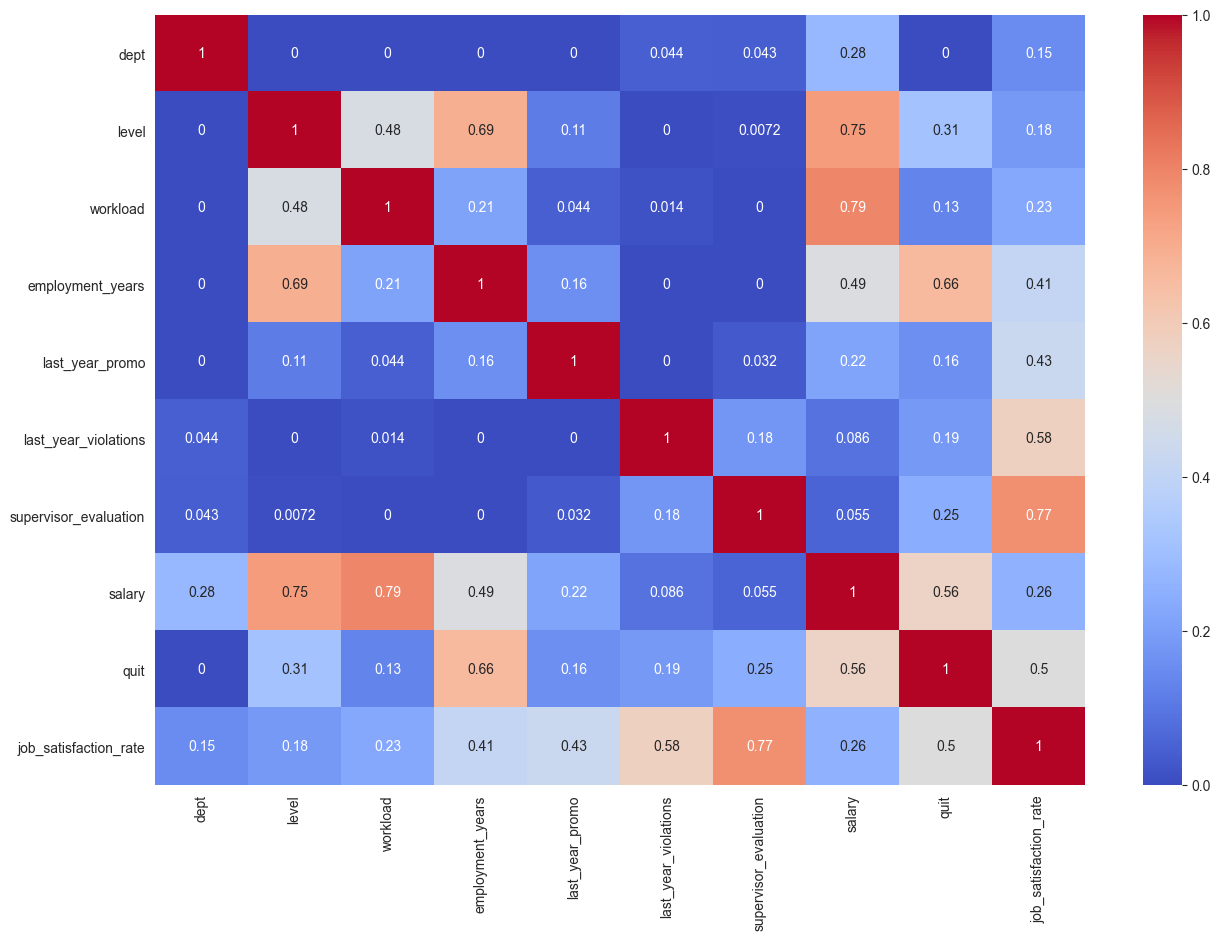

In [67]:
plt.figure(figsize=(15, 10))
#оценка руководителя по сути является ранговой переменной, поэтому в контексте вычисления корреляции признаков мы ее исключим из числа количественных
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate']
sns.heatmap(train_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

- Целевой признак имеет самый высокий коэффициент корреляции со стажем сотрудника, зарплатой и уровнем удовлетворенности. 
- Случаев мультиколинеарности тут ожидаемо много: зарплата, уровень сотрудника и уровень удовлетворенности коррелируют и между собой, и с другими признаками. 

#### Выводы по корреляционному анализу

- Сильнее всего увольнение коррелирует со стажем сотрудника, зарплатой и уровнем удовлетворенности. 
- Мультиколинеарность, как и в случае с первой моделью, устранять пока не будем - сначала посмотрим на результаты. По большому счету она может сильно влиять только на модель логистической регрессии, но на ее показатели еще посмотреть надо (и то - по необходимости).

### Модель прогноза увольнения

#### Создание пайплайна

Создадим модель обучения с учителем для задачи классификации, целью которой является прогноз целевого признака - увольнение сотрудника.

- Создадим пайплайн для теста 3 модели: DecisionTreeRegressor(), LinearRegression().
- Применим метрику ROC-AUC.
- Проанализируем работу моделей.

In [68]:
#создаем выборки
X_train = train_quit.drop(['id', 'quit'], axis=1)
y_train = train_quit['quit']


X_test = test_quit.drop(['id', 'quit'], axis=1)
y_test = test_quit['quit']

#проверим соразмерность двух выборок
print('Размерность обучающих данных:', X_train.shape)
print('Размерность тестовых данных:', X_test.shape)

Размерность обучающих данных: (4000, 9)
Размерность тестовых данных: (2000, 9)


In [69]:
#закодируем целевой признак с LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
label_encoder.classes_

array(['no', 'yes'], dtype=object)

Запомним классы: 
- 'Не уволился' - 0
- 'Уволился' - 1

In [70]:
#создаём списки с названиями признаков: категориальные, категориальные с "вшитым" делением на уровни и числовые признаки
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['supervisor_evaluation', 'level', 'workload']
num_columns = ['salary', 'employment_years', 'job_satisfaction_rate']

#создаём пайплайн подготовки качественных признаков: заполнение пропусков, если вдруг такие случайно будут, и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
    )

#создаём пайплайн подготовки качественных признаков: заполнение пропусков, если они будут, Ordinal-кодирование со списком значений
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[[1, 2, 3, 4, 5],
                           ['junior', 'middle', 'senior'],
                           ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

#создаём общий пайплайн подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])


param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 16),
        'models__max_features': range(2, 16),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']

    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']},

    # Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='l1')],
        'models__C': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

]

#используем поиск по сетке, потому что желаем превратить Яндекс.Облако в Яндекс.Тучу
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print('Параметры лучшей модели:', grid_search.best_params_)
print('')
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Параметры лучшей модели: {'models': DecisionTreeClassifier(random_state=30), 'models__max_depth': 5, 'models__max_features': 13, 'preprocessor__num': StandardScaler()}

Метрика лучшей модели на тренировочной выборке: 0.9277815224265803


In [71]:
prob = grid_search.predict_proba(X_test)[:,1]
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, prob))

Метрика ROC-AUC на тестовой выборке: 0.9219685296035085


#### Анализ работы модели

Accuracy: 0.889
Precision: 0.771
Recall: 0.862



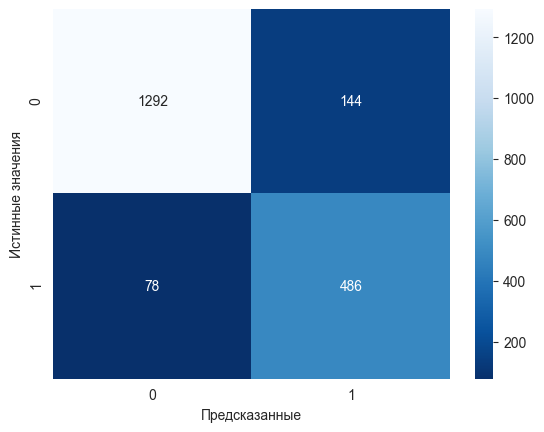

In [72]:
prediction = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)

print('Accuracy:', round(accuracy, 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('') 

cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные')
plt.show;

- У модели в целом хорошие показатели Accuracy, Precision и Recall.
- В данном случае скорее критичны ошибки второго типа, которых модель совершает меньше, чем ошибок первого типа. Найти лучший баланс между точностью и обобщающей способностью можно с помощью выбора порога.

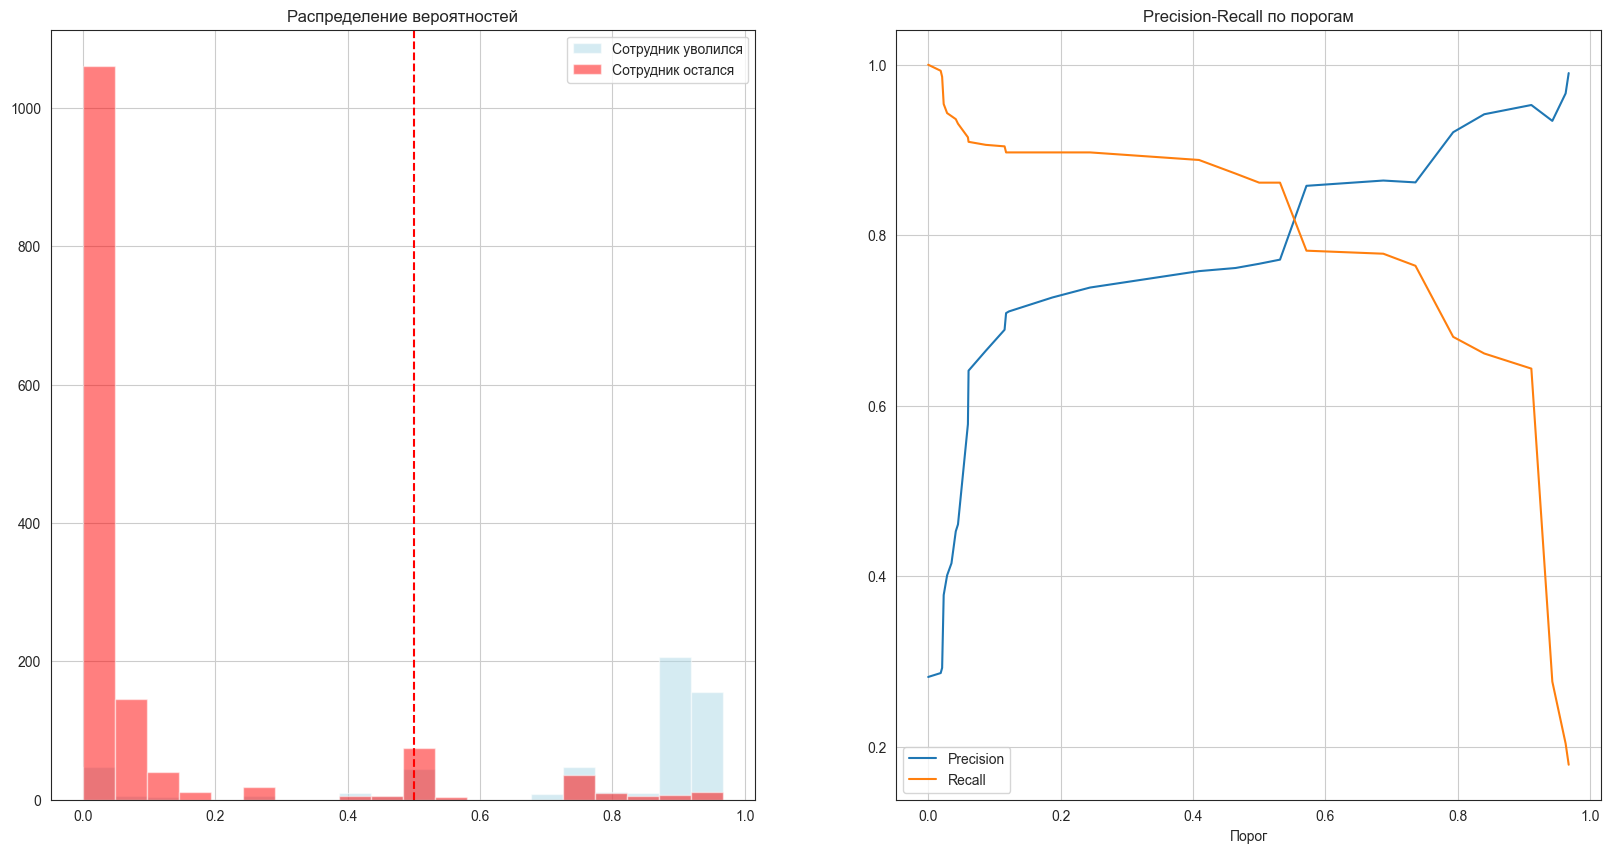

In [73]:
#посмотрим, на каком пороге модель уверенно классифицирует снижение активности
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

axes[0].hist(prob[y_test == 1], bins=20, alpha=0.5, label='Сотрудник уволился', color='#ADD8E6')
axes[0].hist(prob[y_test == 0], bins=20, alpha=0.5, label='Сотрудник остался', color='red')
axes[0].axvline(0.5, color='red', linestyle='--')
axes[0].legend()
axes[0].grid(True)
axes[0].set_title('Распределение вероятностей')

precision, recall, thresholds = precision_recall_curve(y_test, prob)

axes[1].plot(thresholds, precision[:-1], label='Precision')
axes[1].plot(thresholds, recall[:-1], label='Recall')
axes[1].set_xlabel('Порог')
axes[1].legend()
axes[1].grid(True)
axes[1].set_title('Precision-Recall по порогам')

plt.show()

- Рекомендуемый порог модели для выявления риска увольнения - около 0.55. На этом значении достигается идеальный баланс обобщающей способности модели и точности (и обе метрики - Precision и Recall, - больше 0.8)

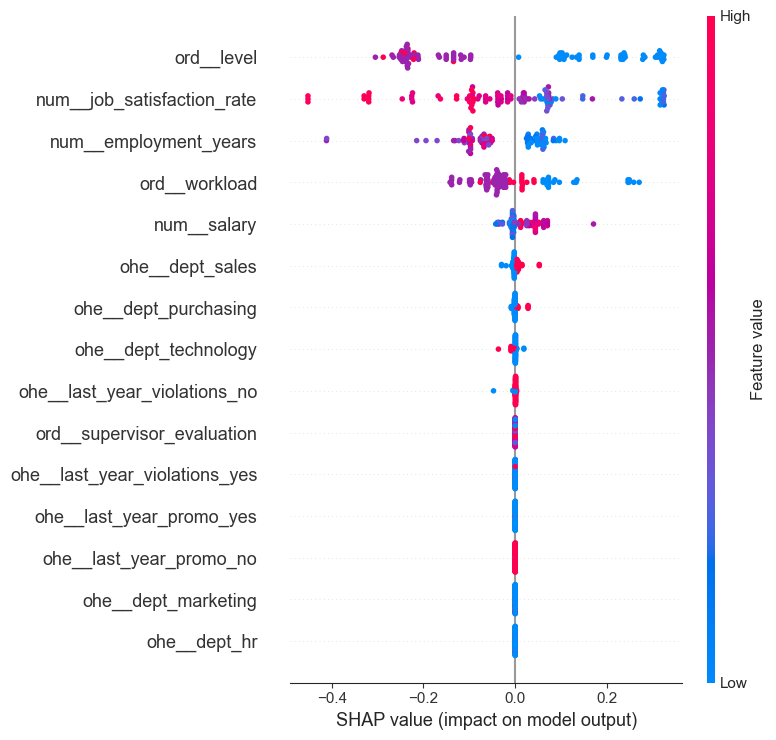

In [74]:
#извлекаем из пайплайна шаги
best_model_pipeline = grid_search.best_estimator_
preprocessor = best_model_pipeline.named_steps['preprocessor']
model = best_model_pipeline.named_steps['models']

#преобразуем выборку
X_train_sample = X_train.sample(100, random_state=RANDOM_STATE)
X_transformed = preprocessor.transform(X_train_sample)
feature_names = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

#создаем TreeExplainer и смотрим SHAP-значения
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_transformed_df)
shap.summary_plot(shap_values[:,:,1], X_transformed_df, feature_names=feature_names)

По SHAP-тесту увольнение сильнее всего связан со следующими признаками:
- **Уровень сотрудника**: низкий профессиональный уровень сотрудника >> высокая вероятность увольнения.
- **Уровень удовлетворенности**: низкий уровень удовлетворенности >> высокая вероятность увольнения.
- **Стаж работы**: маленький стаж работы в компании >> высокая вероятность увольнения.
- **Загруженность**: низкая загруженность или чрезмерная >> высокая вероятность увольнения.
- **Зарплата**: ну очень средняя зарплата >> высокая вероятность увольнения.

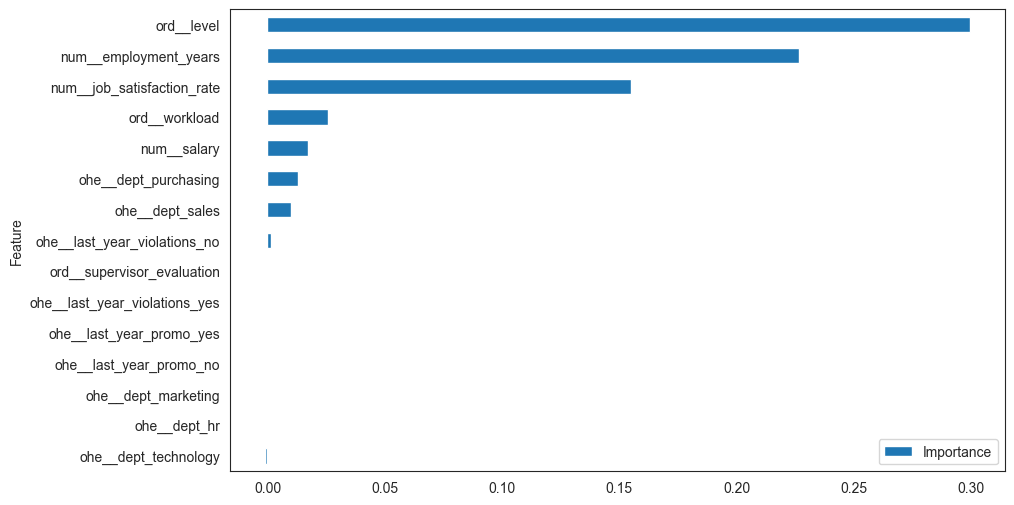

In [75]:
#создаем и преобразуем выборку
sample_for_pi = train_quit.drop(['id'], axis=1).sample(100, random_state=RANDOM_STATE)
X_sample_for_pi = sample_for_pi.drop('quit', axis=1)
y_sample_for_pi = sample_for_pi['quit']
X_for_pi_transformed = preprocessor.transform(X_sample_for_pi)
X_for_pi_transformed_df = pd.DataFrame(X_for_pi_transformed, columns=feature_names)

#проверяем значимость признаков с permutation_importance
result = permutation_importance(model, X_for_pi_transformed, y_sample_for_pi, scoring='roc_auc')

#визуализируем
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

По тесту permutation_importance удовлетворенность работой сильнее всего связана со следующими признаками:
- **Уровень сотрудника**
- **Удовлетворенность работой**
- **Стаж**
- **Загруженность**

Рейтинг топовых признаков идентичен SHAP-тесту.
______

Примечательно, что по тесту permutation_importance также оказался важным - на уровне зарплаты, - отдел сотрудника, если это отдел технический или продаж. Ранее на графиках мы видели, что там процент увольнений очень незначительно, но выше среднего.

#### Выводы по модели прогноза увольнений

Лучше всех проявила себя модель Дерево решений - благодаря более эффективной работе с одинаково важными, хотя и коррелирующими между собой входными признаками, и большей гибкости в настройке гиперпараметров.
_____

Выбранное Дерево решений имеет следующие характеристики:

- max_depth=5
- max_features=13
- препроцессор числовых значений - StandardScaler.
_____

Метрика модели на тесте - 0.92.
____

Рекомендуемый порог модели для выявления риска увольнения - около 0.55. На этом значении достигается идеальный баланс обобщающей способности модели и точности (и обе метрики - Precision и Recall, - больше 0.8)
____

Самыми важными признаками для прогноза удовлетворенности модели являются следующие:

- Уровень сотрудника (низкий профессиональный уровень сотрудника >> высокая вероятность увольнения)
- Уровень удовлетворенности (низкий уровень удовлетворенности >> высокая вероятность увольнения)
- Стаж работы (маленький стаж работы в компании >> высокая вероятность увольнения)
- Загруженность (низкая загруженность или чрезмерная >> высокая вероятность увольнения)

## Общие выводы

**Ход проекта**

**Модель предсказания удовлетворенности сотрудников**
1. **Обзор и предобработка данных**
   - В целом в данных не выявлено значительных недостатков или системных проблем, корректировки минимальны.
2. **Исследовательский анализ данных**
   - Признаки в обучающих и тестовых данных выглядят в целом схоже: распределения, пропорции, средние и медианные значения очень похожи.
   - В обеих выборках не обнаружено аномалий или неадекватных, неправдоподобных значений. 
3. **Корреляционный анализ**
   - Сильнее всего уровень удовлетоворения работой коррелирует с оценкой руководства и наличием нарушений трудового договора со стороны сотрудника.
   - Несмотря на наличие корреляции между входными признаками, все признаки были взяты для дальнейшей работы по обучению модели. Решение было обусловлено работой планируемых моделей в условиях мультиколинеарности: дерево решений не имеет с ней проблем, а показатели модели линейной регрессии надо смотреть на практике, в каждом конкретном случае.
4. **Обучение и выбор моделей**
   - Лучше всех проявила себя модель Дерево решений - благодаря более эффективной работе с одинаково важными, хотя и коррелирующими между собой входными признаками, и большей гибкости в настройке гиперпараметров.
   - Выбранное Дерево решений имеет следующие характеристики: max_depth=14, max_features=12, препроцессор числовых значений - MinMaxScaler.
   - Метрика SMAPE модели на тесте - 14.15.
5. **Анализ важности признаков**
   - Самыми важными признаками для прогноза удовлетворенности модели являются следующие:
     - Оценка руководителя (высокая оценка >> высокая удовлетворенность)
     - Стаж работы (большой стаж >> высокая удовлетворенность)
     - Зарплата (высокая зарплата >> высокая удовлетворенность)
     - Уровень сотрудника (низкий уровень >> высокая удовлетворенность)
     - Отсутствие нарушений ТД
     - Загруженность (низкая загруженность >> высокая удовлетворенность)
____

**Модель предсказания удовлетворенности сотрудников**
1. **Обзор и предобработка данных**
   - В целом в данных не выявлено значительных недостатков или системных проблем, корректировки минимальны.
   - Для дальнейшей работы в обучающий датасет был добавлен столбец с предсказанным значением удовлетворенности сотрудников.
2. **Исследовательский анализ данных**
   - Признаки в обучающих и тестовых данных выглядят в целом схоже: распределения, пропорции, средние и медианные значения очень похожи.
   - В обеих выборках не обнаружено аномалий или неадекватных, неправдоподобных значений.
3. **Анализ признаков в контексте увольнения сотрудников**
   - Признаки, заметно отличающие увольняющихся сотрудников:
     - **Удовлетворенность**. Удовлетворенность ниже среднего. Средний уровень среди увольняющихся - 0.39
     - **Зарплата**. Зарплата ниже среднего. Средняя зарплата среди увольняющихся - 23885
     -  **Стаж**. Стаж работы небольшой, 1-3 года (вероятность чуть выше в сторону меньшего значения).
     -  **Оценка работы руководителем**. Оценка средняя и ниже, 1-3 (вероятность чуть выше в сторону меньшего значения)
     -  **Уровень**. Уровень увольняющихся сотрудников с большой долей вероятности - junior.
     -  **Загруженность**. Уровень загруженности низкий.
    - Признаки второстепенной значимости для описания увольняющихся сотрудников.
      - **Нарушения ТД**. Нарушения ТД встречаются несколько чаще среди увольняющихся.
      - **Повышение**. Среди увольняющихся крайне редко встречаются люди, получившие повышение - но они в принципе редкость в датасете.Признаки в обучающих и тестовых данных выглядят в целом схоже: распределения, пропорции, средние и медианные значения очень похожи.
4. **Корреляционный анализ**
   - Сильнее всего увольнение коррелирует со стажем сотрудника, зарплатой и уровнем удовлетворенности.
   - Мультиколинеарность, как и в случае с первой моделью, устранять не стали до оценки результатов работы моделей.
5. **Обучение и выбор моделей**
   - Лучше всех проявила себя модель Дерево решений - благодаря более эффективной работе с одинаково важными, хотя и коррелирующими между собой входными признаками, и большей гибкости в настройке гиперпараметров.
   - Выбранное Дерево решений имеет следующие характеристики: max_depth=5, max_features=13, препроцессор числовых значений - StandardScaler.
   - Метрика ROC-AUC модели на тесте - 0.92.
   - Рекомендуемый порог модели для выявления риска увольнения - около 0.55. На этом значении достигается идеальный баланс обобщающей способности модели и точности (и обе метрики - Precision и Recall, - больше 0.8)
6. **Анализ важности признаков**
   - Самыми важными признаками для прогноза удовлетворенности модели являются следующие:
     - **Уровень сотрудника** (низкий профессиональный уровень сотрудника >> высокая вероятность увольнения)
     - **Уровень удовлетворенности** (низкий уровень удовлетворенности >> высокая вероятность увольнения)
     - **Стаж** (маленький стаж работы в компании >> высокая вероятность увольнения)
     - **Загруженность** (низкая загруженность или чрезмерная >> высокая вероятность увольнения)руководителя (высокая оценка >> высокая удовлетворенность)
______

**Дополнительные рекомендации**

**Фокус на взращивание молодых сотрудников**

Сотрудники с большим стажем работы в компании и высокой квалификацией (как следствие - с высоким уровнем вовлеченности в проекты и высокой зарплатой) проявляют себя достаточно стабильно. Самые "проблемные" сотрудники - это новички в компании, да и в профессии. Если сотрудник на этом этапе будет неудовлетворен работой, он уволится. Более всего в этом смысле сотрудников мотивируют успехи, выраженные высокой оценкой со стороны руководителя, а следом уже повышениями зарплаты, уровня и т.д. Поэтому важным шагом к удержанию сотрудников являются вложения в их профессиональный рост. Ценны любые шаги в этом направлении: от хорошей связи ментора-ученика с руководителем и курсов повышения квалификации и т.д до вовлечения в интересные проекты, способствующие росту. 
Люди становятся счастливее, когда работа у них хорошо получается, а компания в этом случае имеет причины и ресурсы, чтобы поощрять активность и рост.

**Фокус на оптимизации загруженности**

Оптимизация загруженности - всесторонне полезная мера. Очень высокая загруженность делает людей несчастными, а несчастные люди чаще увольняются. Однако, хотя людям в целом нравится получать зарплату ни за что, перегибы даже в этом направлении чреваты теми же увольнениями - люди просто чувствуют себя ненужными, невовлеченными и никак не развивающимися. 
Оптимальный баланс загруженности не только позитивно скажется на общей удовлетворенности и уровне текучки кадров, но и позволит компании более эффективно использовать человеческий ресурс, повысить продуктивность компании в целом и избежать лишней растраты средств (в т.ч. - на зарплаты для сотрудников, которых и вовсе можно было бы не нанимать).